# Automatic Game Balancing with Top Trumps

Install required packages:

In [1]:
%pip install numpy pymoo

Note: you may need to restart the kernel to use updated packages.


## Configuration

All configurable parameters for the optimization run:

In [2]:
# === CONFIGURATION ===

# Problem parameters (from assignment)
NUM_CARDS = 22              # K: number of cards in deck
NUM_CATEGORIES = 4          # L: number of categories per card
N_SIMULATIONS = 1000        # R: simulations per evaluation (final run)
N_SIMULATIONS_DEV = 100     # R: simulations per evaluation (development)
VALUE_BOUNDS = (1.0, 10.0)  # Card value bounds

# Algorithm parameters
POP_SIZE = 100              # Population size for NSGA-II
N_GEN = 100                 # Number of generations
SEED = 42                   # Random seed for reproducibility
CROSSOVER_PROB = 0.9        # SBX crossover probability
CROSSOVER_ETA = 15          # SBX distribution index
MUTATION_ETA = 20           # Polynomial mutation distribution index

# Runtime settings
DEV_MODE = False             # True: use N_SIMULATIONS_DEV (faster), False: use N_SIMULATIONS
VERBOSE = True              # Print progress during optimization
SAVE_HISTORY = True         # Store algorithm state each generation (for convergence analysis)

# Output settings
OUTPUT_DIR = "./results"    # Directory for saving results

# Derived values
N_VAR = NUM_CARDS * NUM_CATEGORIES  # Total decision variables (88)
R = N_SIMULATIONS_DEV if DEV_MODE else N_SIMULATIONS

print(f"Configuration:")
print(f"  Problem: {NUM_CARDS} cards × {NUM_CATEGORIES} categories = {N_VAR} variables")
print(f"  Simulations per evaluation: {R} ({'DEV' if DEV_MODE else 'FINAL'})")
print(f"  Algorithm: NSGA-II with pop_size={POP_SIZE}, n_gen={N_GEN}")
print(f"  Total evaluations: ~{POP_SIZE * N_GEN:,}")

Configuration:
  Problem: 22 cards × 4 categories = 88 variables
  Simulations per evaluation: 1000 (FINAL)
  Algorithm: NSGA-II with pop_size=100, n_gen=100
  Total evaluations: ~10,000


## Top Trumps Implementation

In [3]:
import random
import numpy as np

class TopTrumpsSimulation:
    """TopTrumpsSimulation implements the basic TopTrumps game engine and agent-based simulation."""

    def __init__(self, num_cards=52, num_categories=6):
        self.K = num_cards  # Number of cards
        self.L = num_categories  # Number of categories

        self.set_random_deck()

    def _normalize_deck(self, deck):
        """Normalizes the deck such that each property is in the range [0,1]. This is required for the p0 agent."""
        min_values = [0] * self.L
        max_values = [0] * self.L

        for cat in range(self.L):
            all_values = [card[cat] for card in deck]
            min_values[cat] = min(all_values)
            max_values[cat] = max(all_values)

        normalized_deck = []

        for card in deck:
            normalized_card = [0] * self.L
            for cat in range(self.L):
                normalized_card[cat] = (card[cat] - min_values[cat]) / (max_values[cat] - min_values[cat])
            normalized_deck.append(normalized_card)

        return normalized_deck

    def set_deck(self, deck_list):
        """Creates a deck from deck_list of length K*L."""

        assert len(deck_list) == self.K * self.L

        deck = np.array_split(deck_list, self.K)

        self.deck = deck
        self._normalized_deck = self._normalize_deck(deck)

    def set_random_deck(self, value_range = (1, 10)):
        """Generates a random deck with values in value_range."""
        deck_list = np.random.uniform(value_range[0], value_range[1], self.K * self.L)
        self.set_deck(deck_list)

    def get_p0_choice(self, card):
        """p0 assumes uniform distribution between max and min values per property and then picks the best value on current card."""
        return card.index(max(card))

    def get_p4_choice(self, card, remaining_cards):
        """p4 calculates exact win probability based on remaining cards."""
        best_prob = -1
        best_cat = 0

        for cat_idx in range(self.L):
            my_val = card[cat_idx]
            # Count how many cards in the potential card pool have a lower value
            wins = sum(1 for opp_card in remaining_cards if my_val > opp_card[cat_idx])
            prob = wins / len(remaining_cards)

            if prob > best_prob:
                best_prob = prob
                best_cat = cat_idx
        # print(f"Best prob: {best_prob:.2f}, cat: {best_cat}")
        return best_cat

    def simulate_game(self):
        # Shuffle and distribute cards
        temp_deck = list(self._normalized_deck)
        random.shuffle(temp_deck)

        # p4 vs p0 setup
        p4_hand = temp_deck[:self.K//2]
        p0_hand = temp_deck[self.K//2:]

        # Track unplayed cards remaining in the 'unplayed' pool for p4's knowledge 
        all_unplayed = list(temp_deck) 

        p4_tricks = 0
        current_turn = random.choice(['p4', 'p0']) # Random starting player
        trick_changes = 0

        # Game ends after all cards played once
        for i in range(self.K // 2):
            card_p4 = p4_hand[i]
            card_p0 = p0_hand[i]

            # Category Selection
            if current_turn == 'p4':
                category = self.get_p4_choice(card_p4, all_unplayed)
            else:
                category = self.get_p0_choice(card_p0)

            # Determine Round Winner
            val_p4 = card_p4[category]
            val_p0 = card_p0[category]

            # Remove current p0, p4 card from p4's tracking memory
            all_unplayed.remove(card_p0)
            all_unplayed.remove(card_p4)

            if val_p4 > val_p0:
                # print("P4 wins!")
                p4_tricks += 1
                if current_turn == 'p0':
                    current_turn = 'p4'
                    trick_changes += 1
            elif val_p0 > val_p4:
                # print("P0 wins!")
                if current_turn == 'p4':
                    current_turn = 'p0'
                    trick_changes += 1
            # In case of draw, current player keeps the lead

        return {
            "p4_tricks": p4_tricks,
            "trick_changes": trick_changes,
            "p4_won": p4_tricks > (self.K / 4) # p4 wins if they got more than half the tricks
        }

Test implementation on a random deck:

In [4]:
num_cards = 22
num_categories = 4
num_repetitions = 1000

sim = TopTrumpsSimulation(num_cards=num_cards, num_categories=num_categories)
sim.set_deck(np.random.uniform(0, 10, num_cards * num_categories))
results = [sim.simulate_game() for _ in range(num_repetitions)]

avg_p4_win_rate = sum(1 for r in results if r['p4_won']) / num_repetitions
avg_tricks = sum(r['p4_tricks'] for r in results) / num_repetitions
avg_trick_changes = sum(r['trick_changes'] for r in results) / num_repetitions

print(f"Results over {num_repetitions} runs:")
print(f"p4 Win Rate: {avg_p4_win_rate:.2%}")
print(f"Average p4 Tricks: {avg_tricks:.2f}")
print(f"Average Trick Changes: {avg_trick_changes:.2f}")

Results over 1000 runs:
p4 Win Rate: 54.80%
Average p4 Tricks: 5.88
Average Trick Changes: 1.97


## Pymoo connection

TopTrumpsBalancing provides a pymoo-compatible interface for TopTrumpsSimulation. Note that the objectives are already negated to result in a minimization problem!

In [5]:
import numpy as np
from pymoo.core.problem import ElementwiseProblem

class TopTrumpsBalancing(ElementwiseProblem):
    """TopTrumpsBalancing connects TopTrumpsSimulation with the pymoo interface ElementwiseProblem."""

    def __init__(self, sim_instance, n_simulations=100):
        self.sim = sim_instance
        self.n_simulations = n_simulations
        
        # KL variables: Number of cards (K) * Categories (L) 
        n_var = self.sim.K * self.sim.L
        
        super().__init__(n_var=n_var,
                         n_obj=2, # Objectives: Fairness (p4 win rate) and Excitement (# trick changes)
                         n_constr=0,
                         xl=1.0, # Lower bound for values
                         xu=10.0) # Upper bound for values

    def _evaluate(self, x, out, *args, **kwargs):
        # Update simulation with the current candidate deck
        self.sim.set_deck(x)
        
        win_rates = []
        trick_changes_list = []
        
        # Perform multiple simulations to get an average
        for _ in range(self.n_simulations):
            res = self.sim.simulate_game()
            win_rates.append(1 if res['p4_won'] else 0)
            trick_changes_list.append(res['trick_changes'])
        
        # Objectives (Minimization):
        # f1: -Average Win Rate of p4 (Fairness)
        # f2: -Average Trick Changes (Excitement)
        out["F"] = [
            -np.mean(win_rates), 
            -np.mean(trick_changes_list)
        ]

Set up simulation and problem instance:

In [6]:
# Set up simulation and problem instance using configuration
my_sim = TopTrumpsSimulation(num_cards=NUM_CARDS, num_categories=NUM_CATEGORIES)
problem = TopTrumpsBalancing(my_sim, n_simulations=R)

print(f"Problem initialized:")
print(f"  Variables: {problem.n_var}")
print(f"  Objectives: {problem.n_obj}")
print(f"  Bounds: [{problem.xl}, {problem.xu}]")

Problem initialized:
  Variables: 88
  Objectives: 2
  Bounds: [[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.], [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]]


Now it's your turn: Optimize `problem` using an approach of your choice and analyze the results. Please refer to the documentation of [pymoo](https://pymoo.org) for more details. A good starting point is: <https://pymoo.org/getting_started/part_2.html#Initialize-an-Algorithm>

## Optimization with NSGA-II

We use NSGA-II (Non-dominated Sorting Genetic Algorithm II) to approximate the Pareto front. NSGA-II uses:
- **Non-dominated sorting**: Solutions are ranked by dominance layers
- **Crowding distance**: Maintains diversity within each layer
- **SBX crossover**: Simulated Binary Crossover for real-valued variables
- **Polynomial mutation**: For exploring the search space

In [7]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.optimize import minimize
from pymoo.core.callback import Callback
from pymoo.indicators.hv import Hypervolume
import os
import time

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Custom callback to track hypervolume, save checkpoints, and best objectives per generation
class OptimizationCallback(Callback):
    def __init__(self, ref_point, checkpoint_freq=10, output_dir="./results"):
        super().__init__()
        self.ref_point = ref_point
        self.hv_indicator = Hypervolume(ref_point=ref_point)
        self.checkpoint_freq = checkpoint_freq
        self.output_dir = output_dir
        self.data["hv"] = []
        self.data["n_eval"] = []
        self.data["best_f1"] = []  # Best fairness (most negative = highest win rate)
        self.data["best_f2"] = []  # Best excitement (most negative = most trick changes)
    
    def notify(self, algorithm):
        # Get current Pareto front approximation
        F = algorithm.opt.get("F")
        X = algorithm.opt.get("X")
        gen = algorithm.n_gen
        
        # Calculate hypervolume
        hv = self.hv_indicator.do(F)
        self.data["hv"].append(hv)
        self.data["n_eval"].append(algorithm.evaluator.n_eval)
        self.data["best_f1"].append(F[:, 0].min())
        self.data["best_f2"].append(F[:, 1].min())
        
        # Save checkpoint every checkpoint_freq generations
        if gen % self.checkpoint_freq == 0:
            np.save(f"{self.output_dir}/checkpoint_F_gen{gen}.npy", F)
            np.save(f"{self.output_dir}/checkpoint_X_gen{gen}.npy", X)
            print(f"  [Checkpoint saved at generation {gen}, HV={hv:.4f}]")

# Reference point for hypervolume (must dominate all possible solutions)
# Since objectives are negated: f1 ∈ [-1, 0], f2 ∈ [-10, 0] approximately
REF_POINT = np.array([0.1, 0.1])  # Slightly above 0 to ensure valid HV

# Checkpoint frequency (save every N generations)
CHECKPOINT_FREQ = 10  # Save every 10 generations for safety

# Initialize algorithm
algorithm = NSGA2(
    pop_size=POP_SIZE,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=CROSSOVER_PROB, eta=CROSSOVER_ETA),
    mutation=PM(eta=MUTATION_ETA),
    eliminate_duplicates=True
)

print("Algorithm configured:")
print(f"  NSGA-II with pop_size={POP_SIZE}")
print(f"  SBX crossover (prob={CROSSOVER_PROB}, eta={CROSSOVER_ETA})")
print(f"  PM mutation (eta={MUTATION_ETA})")
print(f"  Reference point for HV: {REF_POINT}")
print(f"  Checkpoints every {CHECKPOINT_FREQ} generations")

Algorithm configured:
  NSGA-II with pop_size=100
  SBX crossover (prob=0.9, eta=15)
  PM mutation (eta=20)
  Reference point for HV: [0.1 0.1]
  Checkpoints every 10 generations


In [8]:
# Run optimization
print(f"Starting optimization...")
print(f"  Expected evaluations: {POP_SIZE * N_GEN:,}")
print(f"  Estimated time: {POP_SIZE * N_GEN * R * 0.001 / 60:.1f} minutes")
print()

callback = OptimizationCallback(ref_point=REF_POINT)
start_time = time.time()

# Set random seed for reproducibility
np.random.seed(SEED)
random.seed(SEED)

res = minimize(
    problem,
    algorithm,
    ('n_gen', N_GEN),
    seed=SEED,
    callback=callback,
    save_history=SAVE_HISTORY,
    verbose=VERBOSE
)

elapsed_time = time.time() - start_time

print(f"\nOptimization completed in {elapsed_time/60:.1f} minutes")
print(f"  Total evaluations: {res.algorithm.evaluator.n_eval:,}")
print(f"  Pareto front size: {len(res.F)} solutions")

Starting optimization...
  Expected evaluations: 10,000
  Estimated time: 166.7 minutes



n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |      4 |             - |             -


     2 |      200 |      4 |  0.1815856777 |         ideal


     3 |      300 |      6 |  0.1896551724 |         ideal


     4 |      400 |      5 |  0.4615384615 |         ideal


     5 |      500 |      7 |  0.0413583881 |             f


     6 |      600 |      6 |  0.1200353045 |         ideal


     7 |      700 |      3 |  0.0375000000 |         ideal


     8 |      800 |      4 |  0.0924679710 |             f


     9 |      900 |      4 |  0.0187619115 |             f


    10 |     1000 |      5 |  0.1111111111 |         ideal
  [Checkpoint saved at generation 10, HV=2.4742]


    11 |     1100 |      6 |  0.0625000000 |         ideal


    12 |     1200 |      8 |  0.0447832923 |             f


    13 |     1300 |      8 |  0.1192660550 |         ideal


    14 |     1400 |      6 |  0.2935779817 |         ideal


    15 |     1500 |      8 |  0.0394736842 |         ideal


    16 |     1600 |      8 |  0.000000E+00 |             f


    17 |     1700 |      7 |  0.2244897959 |         ideal


    18 |     1800 |      8 |  0.0301204819 |         ideal


    19 |     1900 |      9 |  0.1443298969 |         ideal


    20 |     2000 |      4 |  0.2071428571 |         ideal
  [Checkpoint saved at generation 20, HV=3.0251]


    21 |     2100 |      5 |  0.0133333333 |         ideal


    22 |     2200 |      6 |  0.1176470588 |         ideal


    23 |     2300 |      6 |  0.0454301992 |             f


    24 |     2400 |      7 |  0.1825242718 |         ideal


    25 |     2500 |      8 |  0.0399711038 |             f


    26 |     2600 |      7 |  0.0246526618 |             f


    27 |     2700 |      6 |  0.0963361512 |             f


    28 |     2800 |     11 |  0.0744680851 |         ideal


    29 |     2900 |     11 |  0.0989010989 |         ideal


    30 |     3000 |      8 |  0.1899736148 |         ideal
  [Checkpoint saved at generation 30, HV=3.3336]


    31 |     3100 |      8 |  0.1555555556 |         ideal


    32 |     3200 |      8 |  0.2073011734 |         ideal


    33 |     3300 |      7 |  0.2307692308 |         ideal


    34 |     3400 |     10 |  0.0796178344 |         ideal


    35 |     3500 |     10 |  0.0452151783 |             f


    36 |     3600 |     13 |  0.0193779531 |             f


    37 |     3700 |     15 |  0.0162564054 |             f


    38 |     3800 |     16 |  0.0054860682 |             f


    39 |     3900 |     14 |  0.0494450050 |         ideal


    40 |     4000 |     14 |  0.0215442125 |             f
  [Checkpoint saved at generation 40, HV=3.7666]


    41 |     4100 |     18 |  0.0246062992 |         ideal


    42 |     4200 |     18 |  0.0068640333 |             f


    43 |     4300 |     17 |  0.0045409739 |             f


    44 |     4400 |     16 |  0.0221366699 |         ideal


    45 |     4500 |     19 |  0.0813439434 |         ideal


    46 |     4600 |     17 |  0.0046580240 |             f


    47 |     4700 |     19 |  0.0198675497 |         ideal


    48 |     4800 |     20 |  0.0022393407 |             f


    49 |     4900 |     16 |  0.0117470400 |             f


    50 |     5000 |     17 |  0.0043563853 |             f
  [Checkpoint saved at generation 50, HV=3.9005]


    51 |     5100 |     18 |  0.0033086255 |             f


    52 |     5200 |     18 |  0.0207747761 |             f


    53 |     5300 |     18 |  0.0036849833 |             f


    54 |     5400 |     18 |  0.0061353193 |             f


    55 |     5500 |     20 |  0.0039988549 |             f


    56 |     5600 |     20 |  0.0020041441 |             f


    57 |     5700 |     18 |  0.0077739538 |             f


    58 |     5800 |     19 |  0.0029439525 |             f


    59 |     5900 |     20 |  0.0030426973 |             f


    60 |     6000 |     18 |  0.0047618083 |             f
  [Checkpoint saved at generation 60, HV=3.9094]


    61 |     6100 |     18 |  0.000000E+00 |             f


    62 |     6200 |     21 |  0.0060991124 |             f


    63 |     6300 |     21 |  0.0216494845 |         ideal


    64 |     6400 |     21 |  0.000000E+00 |             f


    65 |     6500 |     23 |  0.0490196078 |         ideal


    66 |     6600 |     21 |  0.0045938149 |             f


    67 |     6700 |     21 |  0.0077871350 |             f


    68 |     6800 |     23 |  0.0135135135 |         ideal


    69 |     6900 |     18 |  0.0038639876 |         ideal


    70 |     7000 |     15 |  0.0099489908 |             f
  [Checkpoint saved at generation 70, HV=3.9884]


    71 |     7100 |     16 |  0.0256024096 |         ideal


    72 |     7200 |     16 |  0.000000E+00 |             f


    73 |     7300 |     20 |  0.0439164867 |         ideal


    74 |     7400 |     21 |  0.0020837840 |             f


    75 |     7500 |     22 |  0.0045246162 |             f


    76 |     7600 |     23 |  0.0499316005 |         ideal


    77 |     7700 |     21 |  0.0020117129 |             f


    78 |     7800 |     21 |  0.0194805195 |         ideal


    79 |     7900 |     22 |  0.0056454551 |             f


    80 |     8000 |     22 |  0.0055937188 |             f
  [Checkpoint saved at generation 80, HV=4.1413]


    81 |     8100 |     24 |  0.0054640768 |             f


    82 |     8200 |     24 |  0.000000E+00 |             f


    83 |     8300 |     24 |  0.000000E+00 |             f


    84 |     8400 |     26 |  0.0025444344 |             f


    85 |     8500 |     23 |  0.0039307828 |             f


    86 |     8600 |     22 |  0.0033812031 |             f


    87 |     8700 |     22 |  0.0080101311 |             f


    88 |     8800 |     24 |  0.0068467408 |             f


    89 |     8900 |     25 |  0.0185185185 |         ideal


    90 |     9000 |     26 |  0.0009165179 |             f
  [Checkpoint saved at generation 90, HV=4.1607]


    91 |     9100 |     27 |  0.0018616835 |             f


    92 |     9200 |     26 |  0.0034154807 |             f


    93 |     9300 |     25 |  0.0033465474 |             f


    94 |     9400 |     26 |  0.0059171598 |         ideal


    95 |     9500 |     26 |  0.0058823529 |         ideal


    96 |     9600 |     26 |  0.0014561902 |             f


    97 |     9700 |     27 |  0.0029495326 |             f


    98 |     9800 |     27 |  0.0020022652 |             f


    99 |     9900 |     28 |  0.0027958760 |             f


   100 |    10000 |     26 |  0.0018181119 |             f
  [Checkpoint saved at generation 100, HV=4.1710]

Optimization completed in 4.1 minutes
  Total evaluations: 10,000
  Pareto front size: 26 solutions


In [9]:
# Extract results
X = res.X  # Decision variables (deck configurations)
F = res.F  # Objective values (negated: fairness, excitement)

# Convert back to interpretable values (un-negate)
fairness = -F[:, 0]      # p4 win rate (higher = more fair)
excitement = -F[:, 1]    # avg trick changes (higher = more exciting)

# Get callback data
hv_history = res.algorithm.callback.data["hv"]
n_eval_history = res.algorithm.callback.data["n_eval"]

# Final hypervolume
final_hv = hv_history[-1] if hv_history else 0

print("Results Summary:")
print(f"  Pareto front size: {len(F)}")
print(f"  Final Hypervolume: {final_hv:.6f}")
print(f"\nObjective Ranges:")
print(f"  Fairness (p4 win rate): [{fairness.min():.3f}, {fairness.max():.3f}]")
print(f"  Excitement (trick changes): [{excitement.min():.2f}, {excitement.max():.2f}]")

Results Summary:
  Pareto front size: 26
  Final Hypervolume: 4.170991

Objective Ranges:
  Fairness (p4 win rate): [0.696, 0.866]
  Excitement (trick changes): [3.07, 4.29]


In [10]:
# Save results to files
timestamp = time.strftime("%Y%m%d_%H%M%S")
mode_str = "dev" if DEV_MODE else "final"

# Save Pareto front (objectives)
np.save(f"{OUTPUT_DIR}/pareto_F_{mode_str}_{timestamp}.npy", F)

# Save decision variables (deck configurations)
np.save(f"{OUTPUT_DIR}/pareto_X_{mode_str}_{timestamp}.npy", X)

# Save convergence history
np.savez(f"{OUTPUT_DIR}/history_{mode_str}_{timestamp}.npz",
         hv=hv_history,
         n_eval=n_eval_history,
         best_f1=res.algorithm.callback.data["best_f1"],
         best_f2=res.algorithm.callback.data["best_f2"])

print(f"Results saved to {OUTPUT_DIR}/")
print(f"  pareto_F_{mode_str}_{timestamp}.npy - Objective values")
print(f"  pareto_X_{mode_str}_{timestamp}.npy - Deck configurations") 
print(f"  history_{mode_str}_{timestamp}.npz - Convergence data")

Results saved to ./results/
  pareto_F_final_20260128_211927.npy - Objective values
  pareto_X_final_20260128_211927.npy - Deck configurations
  history_final_20260128_211927.npz - Convergence data


## Visualization & Analysis

### Pareto Front

The Pareto front shows the trade-off between fairness and excitement. Points on this front are non-dominated - improving one objective necessarily worsens the other.

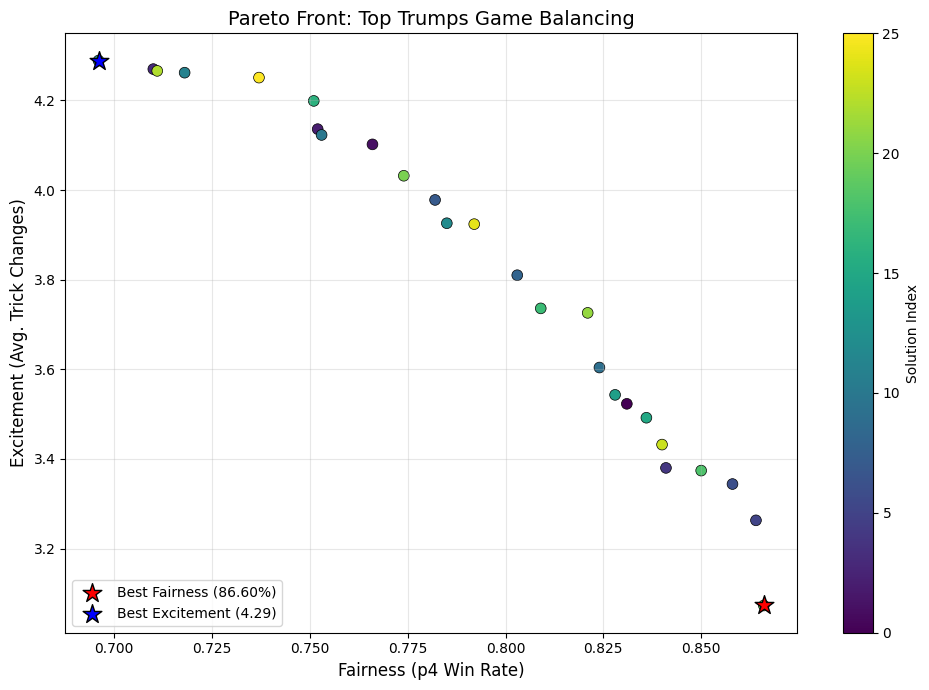

Pareto front saved to ./results/pareto_front_final.png


In [11]:
import matplotlib.pyplot as plt

# Plot Pareto front
fig, ax = plt.subplots(figsize=(10, 7))

scatter = ax.scatter(fairness, excitement, c=np.arange(len(fairness)), 
                     cmap='viridis', s=60, edgecolors='black', linewidth=0.5)

ax.set_xlabel('Fairness (p4 Win Rate)', fontsize=12)
ax.set_ylabel('Excitement (Avg. Trick Changes)', fontsize=12)
ax.set_title('Pareto Front: Top Trumps Game Balancing', fontsize=14)

# Add colorbar to show solution index
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Solution Index', fontsize=10)

# Highlight extreme solutions
best_fair_idx = fairness.argmax()
best_excite_idx = excitement.argmax()

ax.scatter(fairness[best_fair_idx], excitement[best_fair_idx], 
           s=200, marker='*', c='red', edgecolors='black', linewidth=1,
           label=f'Best Fairness ({fairness[best_fair_idx]:.2%})', zorder=5)
ax.scatter(fairness[best_excite_idx], excitement[best_excite_idx], 
           s=200, marker='*', c='blue', edgecolors='black', linewidth=1,
           label=f'Best Excitement ({excitement[best_excite_idx]:.2f})', zorder=5)

ax.legend(loc='lower left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/pareto_front_{mode_str}.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"Pareto front saved to {OUTPUT_DIR}/pareto_front_{mode_str}.png")

### Convergence Analysis

The hypervolume indicator tracks algorithm progress over generations. Higher hypervolume = better Pareto front approximation.

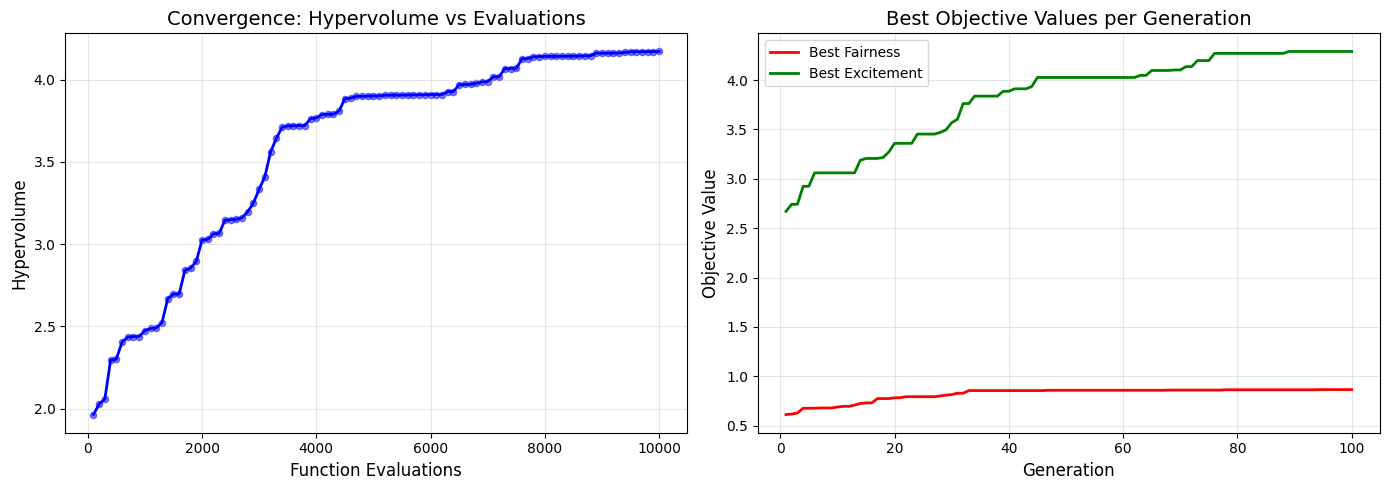

Convergence plot saved to ./results/convergence_final.png


In [12]:
# Convergence plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Hypervolume over evaluations
ax1 = axes[0]
ax1.plot(n_eval_history, hv_history, 'b-', linewidth=2)
ax1.scatter(n_eval_history, hv_history, c='blue', s=20, alpha=0.5)
ax1.set_xlabel('Function Evaluations', fontsize=12)
ax1.set_ylabel('Hypervolume', fontsize=12)
ax1.set_title('Convergence: Hypervolume vs Evaluations', fontsize=14)
ax1.grid(True, alpha=0.3)

# Plot 2: Best objectives over generations
ax2 = axes[1]
generations = np.arange(1, len(hv_history) + 1)
best_f1 = -np.array(res.algorithm.callback.data["best_f1"])  # Un-negate
best_f2 = -np.array(res.algorithm.callback.data["best_f2"])  # Un-negate

ax2.plot(generations, best_f1, 'r-', linewidth=2, label='Best Fairness')
ax2.plot(generations, best_f2, 'g-', linewidth=2, label='Best Excitement')
ax2.set_xlabel('Generation', fontsize=12)
ax2.set_ylabel('Objective Value', fontsize=12)
ax2.set_title('Best Objective Values per Generation', fontsize=14)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/convergence_{mode_str}.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"Convergence plot saved to {OUTPUT_DIR}/convergence_{mode_str}.png")

### Deck Pattern Analysis

Analyzing the structure of extreme solutions to understand what makes a deck fair vs exciting.

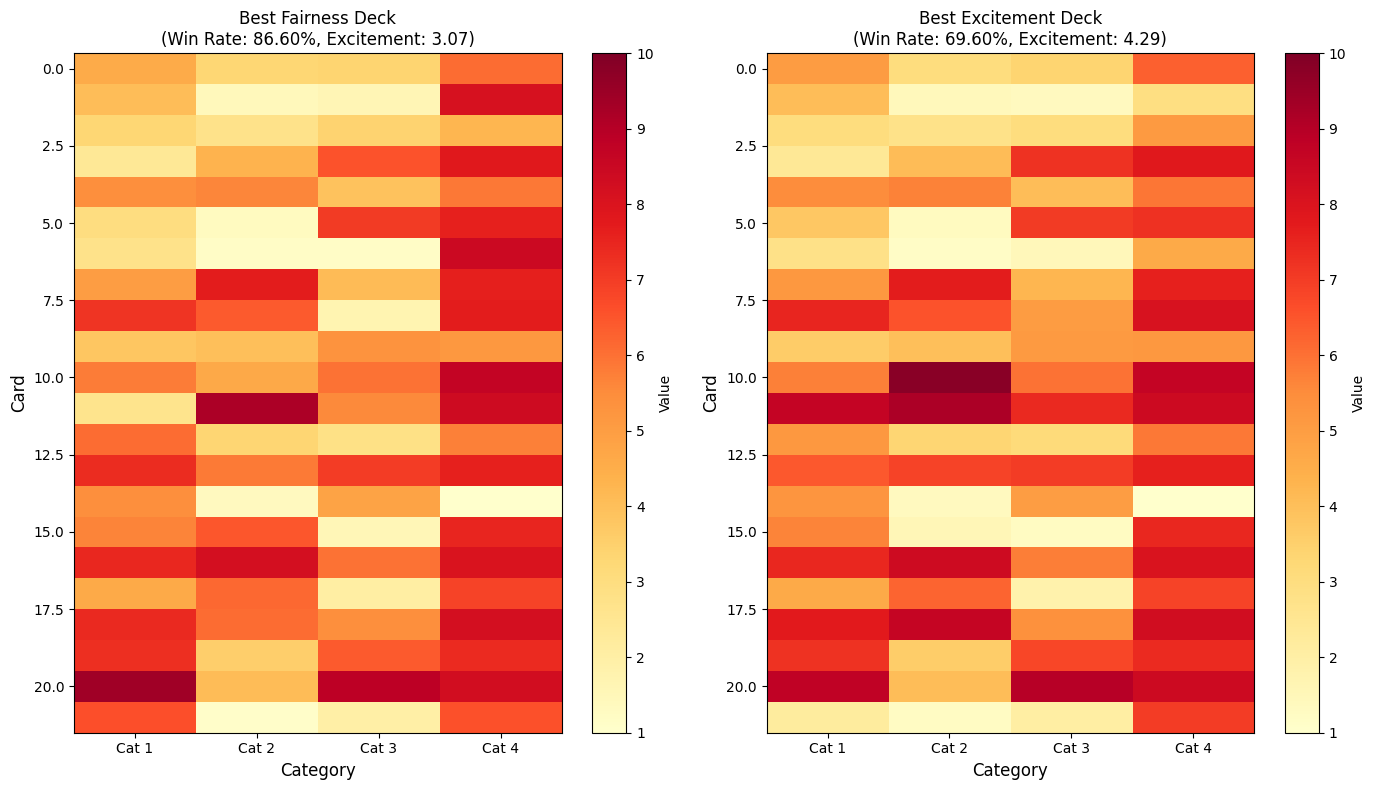

Deck heatmaps saved to ./results/deck_heatmaps_final.png


In [13]:
# Extract extreme solutions
best_fair_deck = X[best_fair_idx].reshape(NUM_CARDS, NUM_CATEGORIES)
best_excite_deck = X[best_excite_idx].reshape(NUM_CARDS, NUM_CATEGORIES)

# Visualize deck structures as heatmaps
fig, axes = plt.subplots(1, 2, figsize=(14, 8))

# Best Fairness Deck
im1 = axes[0].imshow(best_fair_deck, cmap='YlOrRd', aspect='auto', vmin=1, vmax=10)
axes[0].set_xlabel('Category', fontsize=12)
axes[0].set_ylabel('Card', fontsize=12)
axes[0].set_title(f'Best Fairness Deck\n(Win Rate: {fairness[best_fair_idx]:.2%}, Excitement: {excitement[best_fair_idx]:.2f})', fontsize=12)
axes[0].set_xticks(range(NUM_CATEGORIES))
axes[0].set_xticklabels([f'Cat {i+1}' for i in range(NUM_CATEGORIES)])
plt.colorbar(im1, ax=axes[0], label='Value')

# Best Excitement Deck
im2 = axes[1].imshow(best_excite_deck, cmap='YlOrRd', aspect='auto', vmin=1, vmax=10)
axes[1].set_xlabel('Category', fontsize=12)
axes[1].set_ylabel('Card', fontsize=12)
axes[1].set_title(f'Best Excitement Deck\n(Win Rate: {fairness[best_excite_idx]:.2%}, Excitement: {excitement[best_excite_idx]:.2f})', fontsize=12)
axes[1].set_xticks(range(NUM_CATEGORIES))
axes[1].set_xticklabels([f'Cat {i+1}' for i in range(NUM_CATEGORIES)])
plt.colorbar(im2, ax=axes[1], label='Value')

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/deck_heatmaps_{mode_str}.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"Deck heatmaps saved to {OUTPUT_DIR}/deck_heatmaps_{mode_str}.png")

In [14]:
# Statistical comparison of extreme decks
print("Deck Statistics Comparison:")
print("=" * 60)
print(f"{'Metric':<30} {'Best Fairness':>14} {'Best Excitement':>14}")
print("-" * 60)

# Overall statistics
print(f"{'Mean value':<30} {best_fair_deck.mean():>14.3f} {best_excite_deck.mean():>14.3f}")
print(f"{'Std deviation':<30} {best_fair_deck.std():>14.3f} {best_excite_deck.std():>14.3f}")
print(f"{'Min value':<30} {best_fair_deck.min():>14.3f} {best_excite_deck.min():>14.3f}")
print(f"{'Max value':<30} {best_fair_deck.max():>14.3f} {best_excite_deck.max():>14.3f}")

# Per-category statistics
print("-" * 60)
print("Per-category mean:")
for cat in range(NUM_CATEGORIES):
    fair_mean = best_fair_deck[:, cat].mean()
    excite_mean = best_excite_deck[:, cat].mean()
    print(f"  Category {cat+1:<22} {fair_mean:>14.3f} {excite_mean:>14.3f}")

# Per-category variance (indicator of "specialization")
print("-" * 60)
print("Per-category std (specialization indicator):")
for cat in range(NUM_CATEGORIES):
    fair_std = best_fair_deck[:, cat].std()
    excite_std = best_excite_deck[:, cat].std()
    print(f"  Category {cat+1:<22} {fair_std:>14.3f} {excite_std:>14.3f}")

Deck Statistics Comparison:
Metric                          Best Fairness Best Excitement
------------------------------------------------------------
Mean value                              5.274          5.311
Std deviation                           2.281          2.377
Min value                               1.003          1.020
Max value                               9.377          9.791
------------------------------------------------------------
Per-category mean:
  Category 1                               5.321          5.343
  Category 2                               4.446          4.625
  Category 3                               4.386          4.656
  Category 4                               6.942          6.617
------------------------------------------------------------
Per-category std (specialization indicator):
  Category 1                               1.867          1.919
  Category 2                               2.346          2.811
  Category 3                       

## Quality Indicator Summary

Final assessment of the Pareto front approximation quality.

In [15]:
# Final quality summary
print("=" * 60)
print("OPTIMIZATION RESULTS SUMMARY")
print("=" * 60)
print(f"\nProblem Configuration:")
print(f"  Cards (K): {NUM_CARDS}")
print(f"  Categories (L): {NUM_CATEGORIES}")
print(f"  Decision variables: {N_VAR}")
print(f"  Simulations per evaluation (R): {R}")

print(f"\nAlgorithm Configuration:")
print(f"  Algorithm: NSGA-II")
print(f"  Population size: {POP_SIZE}")
print(f"  Generations: {N_GEN}")
print(f"  Total evaluations: {res.algorithm.evaluator.n_eval:,}")

print(f"\nQuality Indicators:")
print(f"  Hypervolume: {final_hv:.6f}")
print(f"  Reference point: {REF_POINT}")
print(f"  Pareto front size: {len(F)} solutions")

print(f"\nObjective Ranges (un-negated):")
print(f"  Fairness (p4 win rate): [{fairness.min():.3f}, {fairness.max():.3f}]")
print(f"  Excitement (trick changes): [{excitement.min():.2f}, {excitement.max():.2f}]")

print(f"\nExtreme Solutions:")
print(f"  Best Fairness: Win rate = {fairness[best_fair_idx]:.2%}, Excitement = {excitement[best_fair_idx]:.2f}")
print(f"  Best Excitement: Win rate = {fairness[best_excite_idx]:.2%}, Excitement = {excitement[best_excite_idx]:.2f}")

print(f"\nRuntime:")
print(f"  Total time: {elapsed_time/60:.1f} minutes")
print(f"  Time per evaluation: {elapsed_time/res.algorithm.evaluator.n_eval:.3f} seconds")

print("\n" + "=" * 60)

OPTIMIZATION RESULTS SUMMARY

Problem Configuration:
  Cards (K): 22
  Categories (L): 4
  Decision variables: 88
  Simulations per evaluation (R): 1000

Algorithm Configuration:
  Algorithm: NSGA-II
  Population size: 100
  Generations: 100
  Total evaluations: 10,000

Quality Indicators:
  Hypervolume: 4.170991
  Reference point: [0.1 0.1]
  Pareto front size: 26 solutions

Objective Ranges (un-negated):
  Fairness (p4 win rate): [0.696, 0.866]
  Excitement (trick changes): [3.07, 4.29]

Extreme Solutions:
  Best Fairness: Win rate = 86.60%, Excitement = 3.07
  Best Excitement: Win rate = 69.60%, Excitement = 4.29

Runtime:
  Total time: 4.1 minutes
  Time per evaluation: 0.025 seconds



## Algorithm Comparison: NSGA-II vs SMS-EMOA vs MOEA/D

We compare three popular multi-objective evolutionary algorithms from the lectures:

1. **NSGA-II** (Non-dominated Sorting Genetic Algorithm II)
   - (μ+μ) strategy with non-dominated sorting + crowding distance
   - Fast, widely used baseline

2. **SMS-EMOA** (S-Metric Selection Evolutionary Multi-objective Optimization Algorithm)
   - (μ+1) steady-state strategy
   - Uses hypervolume contribution for selection
   - Theoretically superior convergence properties

3. **MOEA/D** (Multi-objective Evolutionary Algorithm based on Decomposition)
   - Decomposes problem into weighted single-objective subproblems
   - Uses neighborhood-based mating
   - Efficient for many-objective problems

In [16]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.moo.sms import SMSEMOA
from pymoo.algorithms.moo.moead import MOEAD
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.optimize import minimize
from pymoo.indicators.hv import Hypervolume
import time

# Configuration for comparison
COMP_POP_SIZE = 100
COMP_N_GEN = 100
COMP_SEEDS = [42, 123, 456]  # Multiple seeds for statistical validity

# Reference point for hypervolume (same as before)
REF_POINT = np.array([0.1, 0.1])
hv_indicator = Hypervolume(ref_point=REF_POINT)

# Store results for each algorithm
algorithm_results = {}

print("=" * 60)
print("ALGORITHM COMPARISON EXPERIMENT")
print("=" * 60)
print(f"Population size: {COMP_POP_SIZE}")
print(f"Generations: {COMP_N_GEN}")
print(f"Seeds: {COMP_SEEDS}")
print(f"Simulations per evaluation: {R}")
print("=" * 60)

ALGORITHM COMPARISON EXPERIMENT
Population size: 100
Generations: 100
Seeds: [42, 123, 456]
Simulations per evaluation: 1000


In [17]:
# Define algorithms
def get_algorithms():
    """Create fresh algorithm instances for each run."""
    
    # NSGA-II
    nsga2 = NSGA2(
        pop_size=COMP_POP_SIZE,
        sampling=FloatRandomSampling(),
        crossover=SBX(prob=0.9, eta=15),
        mutation=PM(eta=20),
        eliminate_duplicates=True
    )
    
    # SMS-EMOA (steady-state, hypervolume-based)
    smsemoa = SMSEMOA(
        pop_size=COMP_POP_SIZE,
        sampling=FloatRandomSampling(),
        crossover=SBX(prob=0.9, eta=15),
        mutation=PM(eta=20)
    )
    
    # MOEA/D (decomposition-based)
    # Need reference directions for decomposition
    ref_dirs = get_reference_directions("uniform", 2, n_partitions=COMP_POP_SIZE-1)
    moead = MOEAD(
        ref_dirs=ref_dirs,
        n_neighbors=20,
        sampling=FloatRandomSampling(),
        crossover=SBX(prob=0.9, eta=15),
        mutation=PM(eta=20)
    )
    
    return {
        "NSGA-II": nsga2,
        "SMS-EMOA": smsemoa,
        "MOEA/D": moead
    }

print("Algorithms defined:")
for name in get_algorithms().keys():
    print(f"  - {name}")

Algorithms defined:
  - NSGA-II
  - SMS-EMOA
  - MOEA/D


In [18]:
# Run all algorithms with multiple seeds
for algo_name, algorithm in get_algorithms().items():
    print(f"\n{'='*60}")
    print(f"Running {algo_name}...")
    print(f"{'='*60}")
    
    algo_hvs = []
    algo_times = []
    algo_fronts = []
    
    for seed in COMP_SEEDS:
        print(f"\n  Seed {seed}:")
        
        # Create fresh problem instance for each run
        sim = TopTrumpsSimulation(num_cards=NUM_CARDS, num_categories=NUM_CATEGORIES)
        prob = TopTrumpsBalancing(sim, n_simulations=R)
        
        # Get fresh algorithm instance
        algorithms = get_algorithms()
        algo = algorithms[algo_name]
        
        # Set seeds
        np.random.seed(seed)
        random.seed(seed)
        
        start_time = time.time()
        
        res = minimize(
            prob,
            algo,
            ('n_gen', COMP_N_GEN),
            seed=seed,
            verbose=False
        )
        
        elapsed = time.time() - start_time
        
        # Calculate hypervolume
        hv = hv_indicator.do(res.F)
        
        algo_hvs.append(hv)
        algo_times.append(elapsed)
        algo_fronts.append(res.F)
        
        print(f"    HV: {hv:.4f}, Time: {elapsed/60:.1f} min, Solutions: {len(res.F)}")
    
    # Store results
    algorithm_results[algo_name] = {
        "hvs": algo_hvs,
        "times": algo_times,
        "fronts": algo_fronts,
        "hv_mean": np.mean(algo_hvs),
        "hv_std": np.std(algo_hvs),
        "time_mean": np.mean(algo_times),
    }
    
    print(f"\n  {algo_name} Summary:")
    print(f"    HV: {np.mean(algo_hvs):.4f} ± {np.std(algo_hvs):.4f}")
    print(f"    Avg Time: {np.mean(algo_times)/60:.1f} min")

print("\n" + "="*60)
print("All algorithms completed!")
print("="*60)


Running NSGA-II...

  Seed 42:


    HV: 4.1710, Time: 4.0 min, Solutions: 26

  Seed 123:


    HV: 4.5476, Time: 4.0 min, Solutions: 34

  Seed 456:


    HV: 4.5325, Time: 3.9 min, Solutions: 35

  NSGA-II Summary:
    HV: 4.4170 ± 0.1741
    Avg Time: 4.0 min

Running SMS-EMOA...

  Seed 42:


    HV: 4.6149, Time: 4.0 min, Solutions: 32

  Seed 123:


    HV: 4.3004, Time: 4.0 min, Solutions: 23

  Seed 456:


    HV: 4.2552, Time: 4.0 min, Solutions: 15

  SMS-EMOA Summary:
    HV: 4.3901 ± 0.1600
    Avg Time: 4.0 min

Running MOEA/D...

  Seed 42:


    HV: 2.8686, Time: 3.8 min, Solutions: 55

  Seed 123:


    HV: 2.9952, Time: 3.9 min, Solutions: 58

  Seed 456:


    HV: 2.7022, Time: 3.8 min, Solutions: 53

  MOEA/D Summary:
    HV: 2.8553 ± 0.1200
    Avg Time: 3.9 min

All algorithms completed!


### Algorithm Comparison Results

In [19]:
# Summary table
print("=" * 70)
print("ALGORITHM COMPARISON SUMMARY")
print("=" * 70)
print(f"{'Algorithm':<15} {'HV Mean':>12} {'HV Std':>10} {'Avg Time':>12} {'Best HV':>12}")
print("-" * 70)

best_algo = None
best_hv = 0

for algo_name, results in algorithm_results.items():
    hv_mean = results["hv_mean"]
    hv_std = results["hv_std"]
    time_mean = results["time_mean"]
    best_run_hv = max(results["hvs"])
    
    print(f"{algo_name:<15} {hv_mean:>12.4f} {hv_std:>10.4f} {time_mean/60:>10.1f} min {best_run_hv:>12.4f}")
    
    if hv_mean > best_hv:
        best_hv = hv_mean
        best_algo = algo_name

print("-" * 70)
print(f"Best algorithm by mean HV: {best_algo} ({best_hv:.4f})")
print("=" * 70)

ALGORITHM COMPARISON SUMMARY
Algorithm            HV Mean     HV Std     Avg Time      Best HV
----------------------------------------------------------------------
NSGA-II               4.4170     0.1741        4.0 min       4.5476
SMS-EMOA              4.3901     0.1600        4.0 min       4.6149
MOEA/D                2.8553     0.1200        3.9 min       2.9952
----------------------------------------------------------------------
Best algorithm by mean HV: NSGA-II (4.4170)


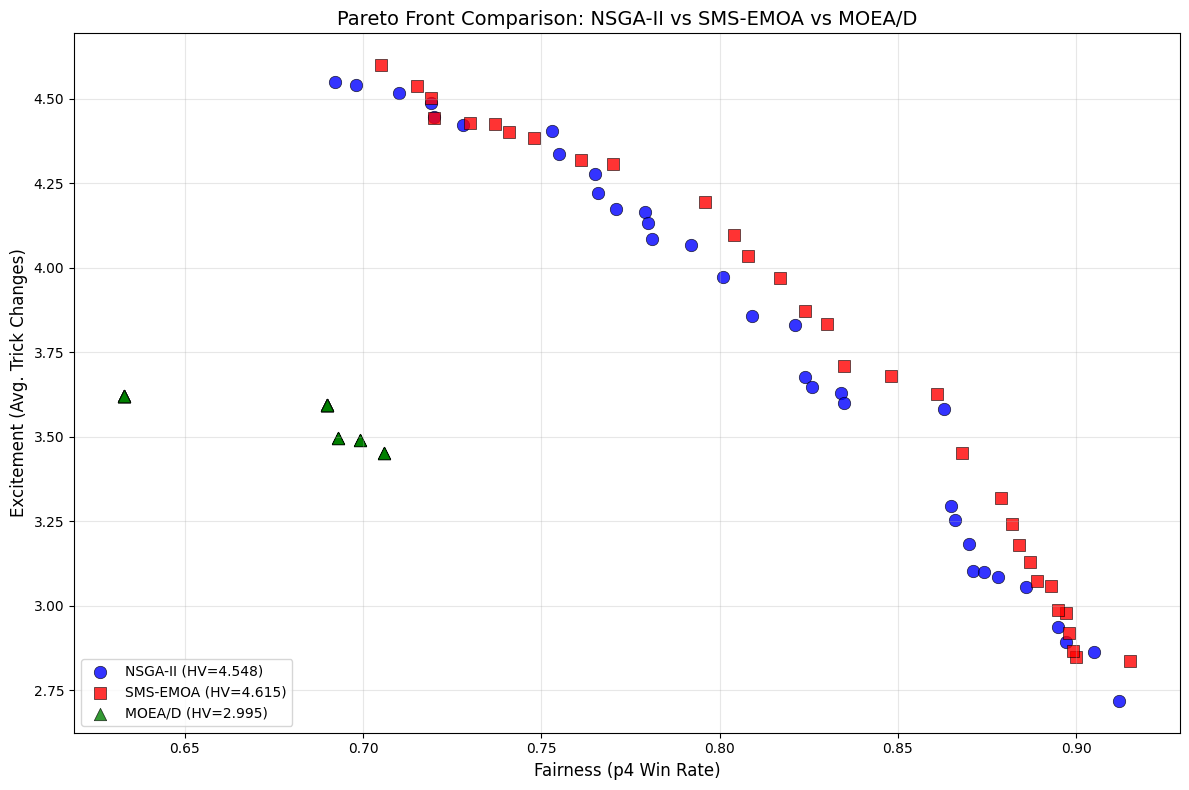

Saved: ./results/algorithm_comparison_pareto.png


In [20]:
# Visualization 1: Pareto fronts comparison (best run from each algorithm)
fig, ax = plt.subplots(figsize=(12, 8))

colors = {'NSGA-II': 'blue', 'SMS-EMOA': 'red', 'MOEA/D': 'green'}
markers = {'NSGA-II': 'o', 'SMS-EMOA': 's', 'MOEA/D': '^'}

for algo_name, results in algorithm_results.items():
    # Get best run (highest HV)
    best_idx = np.argmax(results["hvs"])
    F = results["fronts"][best_idx]
    
    # Un-negate objectives
    fair = -F[:, 0]
    excite = -F[:, 1]
    
    ax.scatter(fair, excite, c=colors[algo_name], marker=markers[algo_name], 
               s=80, label=f'{algo_name} (HV={results["hvs"][best_idx]:.3f})',
               edgecolors='black', linewidth=0.5, alpha=0.8)

ax.set_xlabel('Fairness (p4 Win Rate)', fontsize=12)
ax.set_ylabel('Excitement (Avg. Trick Changes)', fontsize=12)
ax.set_title('Pareto Front Comparison: NSGA-II vs SMS-EMOA vs MOEA/D', fontsize=14)
ax.legend(loc='lower left', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/algorithm_comparison_pareto.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"Saved: {OUTPUT_DIR}/algorithm_comparison_pareto.png")

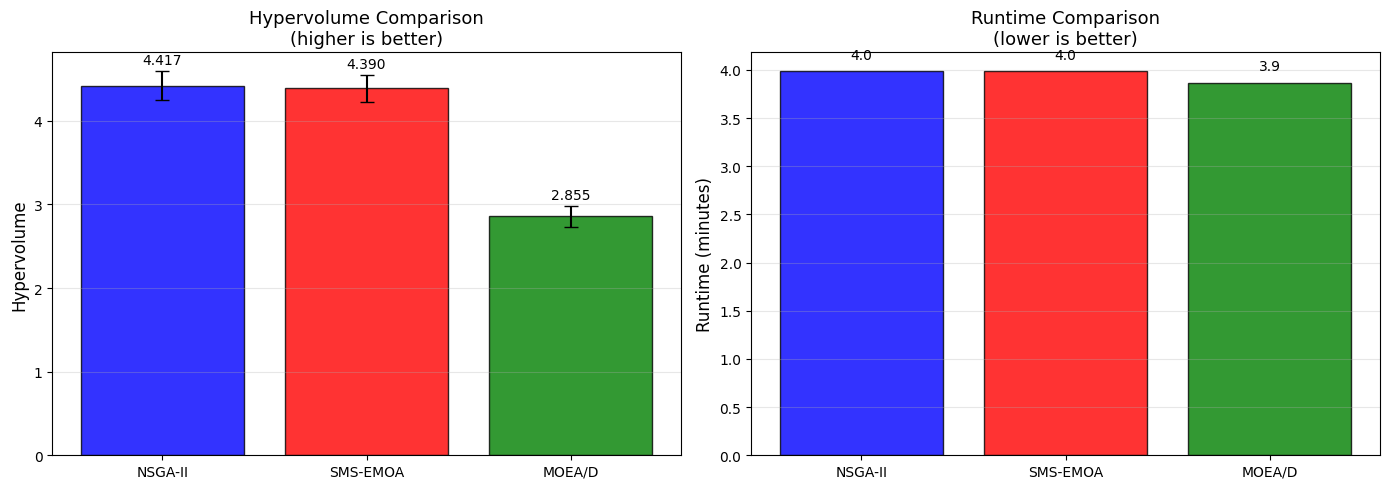

Saved: ./results/algorithm_comparison_bars.png


In [21]:
# Visualization 2: Hypervolume comparison (bar chart with error bars)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

algo_names = list(algorithm_results.keys())
hv_means = [algorithm_results[a]["hv_mean"] for a in algo_names]
hv_stds = [algorithm_results[a]["hv_std"] for a in algo_names]
time_means = [algorithm_results[a]["time_mean"]/60 for a in algo_names]

colors_list = [colors[a] for a in algo_names]

# Plot 1: Hypervolume comparison
ax1 = axes[0]
bars1 = ax1.bar(algo_names, hv_means, yerr=hv_stds, capsize=5, 
                color=colors_list, edgecolor='black', alpha=0.8)
ax1.set_ylabel('Hypervolume', fontsize=12)
ax1.set_title('Hypervolume Comparison\n(higher is better)', fontsize=13)
ax1.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, mean, std in zip(bars1, hv_means, hv_stds):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + std + 0.05,
             f'{mean:.3f}', ha='center', va='bottom', fontsize=10)

# Plot 2: Runtime comparison
ax2 = axes[1]
bars2 = ax2.bar(algo_names, time_means, color=colors_list, edgecolor='black', alpha=0.8)
ax2.set_ylabel('Runtime (minutes)', fontsize=12)
ax2.set_title('Runtime Comparison\n(lower is better)', fontsize=13)
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, t in zip(bars2, time_means):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
             f'{t:.1f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/algorithm_comparison_bars.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"Saved: {OUTPUT_DIR}/algorithm_comparison_bars.png")

In [22]:
# Save comparison results
comparison_data = {
    "algorithms": algo_names,
    "hv_means": hv_means,
    "hv_stds": hv_stds,
    "time_means": time_means,
    "seeds": COMP_SEEDS,
    "pop_size": COMP_POP_SIZE,
    "n_gen": COMP_N_GEN,
    "n_simulations": R
}

np.savez(f"{OUTPUT_DIR}/algorithm_comparison.npz", **comparison_data)

# Also save individual Pareto fronts
for algo_name, results in algorithm_results.items():
    best_idx = np.argmax(results["hvs"])
    safe_name = algo_name.replace('-', '_').replace('/', '_').lower()
    np.save(f"{OUTPUT_DIR}/pareto_F_{safe_name}.npy", 
            results["fronts"][best_idx])

print(f"Comparison results saved to {OUTPUT_DIR}/algorithm_comparison.npz")
print("Individual Pareto fronts saved for each algorithm.")

Comparison results saved to ./results/algorithm_comparison.npz
Individual Pareto fronts saved for each algorithm.


## Performance Optimization with Numba

The game simulation is the bottleneck - each evaluation runs R=1000 simulations. We can achieve significant speedup using **Numba**, a Just-In-Time (JIT) compiler that translates Python to optimized machine code.

### Key Optimizations:
1. **JIT Compilation**: `@njit` decorator compiles functions to machine code
2. **NumPy Arrays**: Replace Python lists with fixed-size arrays
3. **Boolean Masks**: Use masks instead of list `.remove()` operations
4. **No Classes**: Numba works with functions and arrays, not Python objects

In [23]:
# Install Numba if not already installed
%pip install numba

Note: you may need to restart the kernel to use updated packages.


In [24]:
from numba import njit
import numpy as np

@njit(cache=True)
def simulate_game_numba(deck_normalized, K, L):
    """
    Numba-optimized game simulation.
    
    Parameters:
    -----------
    deck_normalized : np.ndarray of shape (K, L)
        Pre-normalized deck where each column is scaled to [0, 1]
    K : int
        Number of cards
    L : int
        Number of categories
    
    Returns:
    --------
    p4_tricks : int
        Number of tricks won by p4
    trick_changes : int
        Number of times the lead changed
    p4_won : bool
        Whether p4 won the game
    """
    K_half = K // 2

    # Shuffle card indices
    indices = np.arange(K)
    np.random.shuffle(indices)
    
    # Distribute cards
    p4_indices = indices[:K_half]
    p0_indices = indices[K_half:]
    
    # Game state
    p4_tricks = 0
    current_is_p4 = np.random.random() > 0.5
    trick_changes = 0
    
    # Track remaining cards with a compact index list and position map
    remaining = np.arange(K)
    pos = np.arange(K)
    n_remaining = K
    
    # Play K/2 rounds
    for round_idx in range(K_half):
        p4_card_idx = p4_indices[round_idx]
        p0_card_idx = p0_indices[round_idx]
        
        card_p4 = deck_normalized[p4_card_idx]
        card_p0 = deck_normalized[p0_card_idx]
        
        # Determine category choice
        if current_is_p4:
            # p4 strategy: calculate exact win probability for each category
            best_prob = -1.0
            best_cat = 0
            
            for cat in range(L):
                my_val = card_p4[cat]
                wins = 0
                
                # Count wins against remaining cards (compact list)
                for r in range(n_remaining):
                    card_idx = remaining[r]
                    if my_val > deck_normalized[card_idx, cat]:
                        wins += 1
                
                prob = wins / n_remaining
                if prob > best_prob:
                    best_prob = prob
                    best_cat = cat
            
            category = best_cat
        else:
            # p0 strategy: pick category with highest normalized value
            best_cat = 0
            best_val = card_p0[0]
            
            for cat in range(1, L):
                val = card_p0[cat]
                if val > best_val:
                    best_val = val
                    best_cat = cat
            
            category = best_cat
        
        # Compare values
        val_p4 = card_p4[category]
        val_p0 = card_p0[category]
        
        # Remove played cards from remaining pool (swap remove)
        idx = pos[p4_card_idx]
        last = remaining[n_remaining - 1]
        remaining[idx] = last
        pos[last] = idx
        n_remaining -= 1
        
        idx = pos[p0_card_idx]
        last = remaining[n_remaining - 1]
        remaining[idx] = last
        pos[last] = idx
        n_remaining -= 1
        
        # Determine round winner
        if val_p4 > val_p0:
            p4_tricks += 1
            if not current_is_p4:
                current_is_p4 = True
                trick_changes += 1
        elif val_p0 > val_p4:
            if current_is_p4:
                current_is_p4 = False
                trick_changes += 1
        # Draw: current player keeps lead
    
    p4_won = p4_tricks > K // 4
    return p4_tricks, trick_changes, p4_won


@njit(cache=True)
def run_simulations_numba(deck_normalized, K, L, n_simulations):
    """
    Run multiple game simulations and return average metrics.
    
    This function is also JIT-compiled for maximum performance.
    """
    total_wins = 0
    total_trick_changes = 0
    
    for _ in range(n_simulations):
        p4_tricks, trick_changes, p4_won = simulate_game_numba(deck_normalized, K, L)
        if p4_won:
            total_wins += 1
        total_trick_changes += trick_changes
    
    avg_win_rate = total_wins / n_simulations
    avg_trick_changes = total_trick_changes / n_simulations
    
    return avg_win_rate, avg_trick_changes


def normalize_deck(deck_flat, K, L):
    """
    Normalize deck values to [0, 1] per category.
    
    This runs in Python (not Numba) since it's only called once per evaluation.
    """
    deck = deck_flat.reshape(K, L).astype(np.float64, copy=False)
    
    col_min = deck.min(axis=0)
    col_max = deck.max(axis=0)
    denom = col_max - col_min
    denom_safe = np.where(denom > 0.0, denom, 1.0)
    
    deck_normalized = (deck - col_min) / denom_safe
    zero_mask = denom == 0.0
    if np.any(zero_mask):
        deck_normalized[:, zero_mask] = 0.5  # All same value
    
    return np.asfortranarray(deck_normalized)


print("Numba-optimized functions defined.")
print("First call will trigger JIT compilation (one-time cost).")



Numba-optimized functions defined.
First call will trigger JIT compilation (one-time cost).


### Benchmark: Original vs Numba

In [25]:
import time

# Create test deck
test_deck = np.random.uniform(1, 10, NUM_CARDS * NUM_CATEGORIES)
test_deck_normalized = normalize_deck(test_deck, NUM_CARDS, NUM_CATEGORIES)

# Warm up Numba (JIT compilation happens on first call)
print("Warming up Numba (JIT compilation)...")
_ = simulate_game_numba(test_deck_normalized, NUM_CARDS, NUM_CATEGORIES)
_ = run_simulations_numba(test_deck_normalized, NUM_CARDS, NUM_CATEGORIES, 10)
print("Compilation complete.\n")

# Benchmark parameters
N_GAMES = 10000
N_EVALS = 100  # Number of evaluation calls to simulate

# --- Benchmark Original Implementation ---
print("Benchmarking ORIGINAL implementation...")
original_sim = TopTrumpsSimulation(num_cards=NUM_CARDS, num_categories=NUM_CATEGORIES)
original_sim.set_deck(test_deck)

start = time.perf_counter()
for _ in range(N_GAMES):
    original_sim.simulate_game()
original_time = time.perf_counter() - start
original_per_game = original_time / N_GAMES * 1e6  # microseconds

print(f"  {N_GAMES} games in {original_time:.3f}s")
print(f"  {original_per_game:.2f} µs per game")

# --- Benchmark Numba Implementation ---
print("\nBenchmarking NUMBA implementation...")

start = time.perf_counter()
for _ in range(N_GAMES):
    simulate_game_numba(test_deck_normalized, NUM_CARDS, NUM_CATEGORIES)
numba_time = time.perf_counter() - start
numba_per_game = numba_time / N_GAMES * 1e6  # microseconds

print(f"  {N_GAMES} games in {numba_time:.3f}s")
print(f"  {numba_per_game:.2f} µs per game")

# --- Benchmark Full Evaluation (R simulations) ---
print(f"\nBenchmarking full evaluation ({R} simulations)...")

# Original
start = time.perf_counter()
for _ in range(N_EVALS):
    original_sim.set_deck(np.random.uniform(1, 10, NUM_CARDS * NUM_CATEGORIES))
    wins = sum(1 for _ in range(R) if original_sim.simulate_game()['p4_won'])
original_eval_time = (time.perf_counter() - start) / N_EVALS * 1000  # ms

# Numba
start = time.perf_counter()
for _ in range(N_EVALS):
    deck = np.random.uniform(1, 10, NUM_CARDS * NUM_CATEGORIES)
    deck_norm = normalize_deck(deck, NUM_CARDS, NUM_CATEGORIES)
    run_simulations_numba(deck_norm, NUM_CARDS, NUM_CATEGORIES, R)
numba_eval_time = (time.perf_counter() - start) / N_EVALS * 1000  # ms

print(f"  Original: {original_eval_time:.2f} ms per evaluation")
print(f"  Numba:    {numba_eval_time:.2f} ms per evaluation")

# --- Summary ---
speedup_game = original_per_game / numba_per_game
speedup_eval = original_eval_time / numba_eval_time

print("\n" + "=" * 50)
print("SPEEDUP SUMMARY")
print("=" * 50)
print(f"Per game:       {speedup_game:.1f}x faster")
print(f"Per evaluation: {speedup_eval:.1f}x faster")
print(f"\nProjected algorithm run time:")
print(f"  Original: ~{N_GEN * POP_SIZE * original_eval_time / 1000 / 60:.1f} min")
print(f"  Numba:    ~{N_GEN * POP_SIZE * numba_eval_time / 1000 / 60:.1f} min")
print("=" * 50)

Warming up Numba (JIT compilation)...


Compilation complete.

Benchmarking ORIGINAL implementation...


  10000 games in 0.230s
  23.03 µs per game

Benchmarking NUMBA implementation...
  10000 games in 0.006s
  0.61 µs per game

Benchmarking full evaluation (1000 simulations)...


  Original: 21.96 ms per evaluation
  Numba:    0.46 ms per evaluation

SPEEDUP SUMMARY
Per game:       38.0x faster
Per evaluation: 48.2x faster

Projected algorithm run time:
  Original: ~3.7 min
  Numba:    ~0.1 min


### Numba-Optimized Problem Class

In [26]:
from pymoo.core.problem import ElementwiseProblem

class TopTrumpsBalancingNumba(ElementwiseProblem):
    """
    Numba-optimized version of TopTrumpsBalancing.
    
    Uses JIT-compiled simulation functions for ~10x speedup.
    """
    
    def __init__(self, num_cards=22, num_categories=4, n_simulations=1000):
        self.K = num_cards
        self.L = num_categories
        self.n_simulations = n_simulations
        
        n_var = num_cards * num_categories
        
        super().__init__(
            n_var=n_var,
            n_obj=2,
            n_constr=0,
            xl=1.0,
            xu=10.0
        )
    
    def _evaluate(self, x, out, *args, **kwargs):
        # Normalize deck (Python - runs once per evaluation)
        deck_normalized = normalize_deck(x, self.K, self.L)
        
        # Run simulations (Numba - fast)
        avg_win_rate, avg_trick_changes = run_simulations_numba(
            deck_normalized, self.K, self.L, self.n_simulations
        )
        
        # Objectives (negated for minimization)
        out["F"] = [-avg_win_rate, -avg_trick_changes]


# Create Numba problem instance
problem_numba = TopTrumpsBalancingNumba(
    num_cards=NUM_CARDS, 
    num_categories=NUM_CATEGORIES, 
    n_simulations=R
)

print(f"Numba problem initialized:")
print(f"  Variables: {problem_numba.n_var}")
print(f"  Objectives: {problem_numba.n_obj}")
print(f"  Simulations per evaluation: {problem_numba.n_simulations}")

Numba problem initialized:
  Variables: 88
  Objectives: 2
  Simulations per evaluation: 1000


### Re-run Algorithm Comparison with Numba

Now we re-run the same experiment with the Numba-optimized problem class.

In [27]:
# Store results for Numba runs
algorithm_results_numba = {}

print("=" * 60)
print("ALGORITHM COMPARISON WITH NUMBA OPTIMIZATION")
print("=" * 60)
print(f"Population size: {COMP_POP_SIZE}")
print(f"Generations: {COMP_N_GEN}")
print(f"Seeds: {COMP_SEEDS}")
print(f"Simulations per evaluation: {R}")
print("=" * 60)

total_start = time.time()

for algo_name in ["NSGA-II", "SMS-EMOA", "MOEA/D"]:
    print(f"\n{'='*60}")
    print(f"Running {algo_name} (Numba)...")
    print(f"{'='*60}")
    
    algo_hvs = []
    algo_times = []
    algo_fronts = []
    
    for seed in COMP_SEEDS:
        print(f"\n  Seed {seed}:", end=" ")
        
        # Create fresh Numba problem instance
        prob = TopTrumpsBalancingNumba(
            num_cards=NUM_CARDS,
            num_categories=NUM_CATEGORIES,
            n_simulations=R
        )
        
        # Get fresh algorithm instance
        algorithms = get_algorithms()
        algo = algorithms[algo_name]
        
        # Set seeds
        np.random.seed(seed)
        random.seed(seed)
        
        start_time = time.time()
        
        res = minimize(
            prob,
            algo,
            ('n_gen', COMP_N_GEN),
            seed=seed,
            verbose=False
        )
        
        elapsed = time.time() - start_time
        
        # Calculate hypervolume
        hv = hv_indicator.do(res.F)
        
        algo_hvs.append(hv)
        algo_times.append(elapsed)
        algo_fronts.append(res.F)
        
        print(f"HV: {hv:.4f}, Time: {elapsed:.1f}s, Solutions: {len(res.F)}")
    
    # Store results
    algorithm_results_numba[algo_name] = {
        "hvs": algo_hvs,
        "times": algo_times,
        "fronts": algo_fronts,
        "hv_mean": np.mean(algo_hvs),
        "hv_std": np.std(algo_hvs),
        "time_mean": np.mean(algo_times),
    }
    
    print(f"\n  {algo_name} Summary:")
    print(f"    HV: {np.mean(algo_hvs):.4f} ± {np.std(algo_hvs):.4f}")
    print(f"    Avg Time: {np.mean(algo_times):.1f}s")

total_elapsed = time.time() - total_start

print("\n" + "="*60)
print(f"All algorithms completed in {total_elapsed:.1f}s ({total_elapsed/60:.1f} min)")
print("="*60)

ALGORITHM COMPARISON WITH NUMBA OPTIMIZATION
Population size: 100
Generations: 100
Seeds: [42, 123, 456]
Simulations per evaluation: 1000

Running NSGA-II (Numba)...

  Seed 42: 

HV: 4.3075, Time: 5.2s, Solutions: 24

  Seed 123: 

HV: 4.4037, Time: 5.2s, Solutions: 33

  Seed 456: 

HV: 4.5422, Time: 5.4s, Solutions: 45

  NSGA-II Summary:
    HV: 4.4178 ± 0.0963
    Avg Time: 5.2s

Running SMS-EMOA (Numba)...

  Seed 42: 

HV: 4.4915, Time: 5.5s, Solutions: 27

  Seed 123: 

HV: 3.9829, Time: 5.5s, Solutions: 20

  Seed 456: 

HV: 4.4513, Time: 5.3s, Solutions: 30

  SMS-EMOA Summary:
    HV: 4.3086 ± 0.2308
    Avg Time: 5.4s

Running MOEA/D (Numba)...

  Seed 42: 

HV: 2.7478, Time: 6.9s, Solutions: 37

  Seed 123: 

HV: 3.2208, Time: 7.0s, Solutions: 40

  Seed 456: 

HV: 2.9381, Time: 6.9s, Solutions: 64

  MOEA/D Summary:
    HV: 2.9689 ± 0.1943
    Avg Time: 7.0s

All algorithms completed in 52.9s (0.9 min)


In [28]:
# Compare Original vs Numba performance
print("=" * 70)
print("SPEEDUP COMPARISON: ORIGINAL vs NUMBA")
print("=" * 70)
print(f"{'Algorithm':<15} {'Original Time':>15} {'Numba Time':>15} {'Speedup':>10}")
print("-" * 70)

for algo_name in algorithm_results.keys():
    orig_time = algorithm_results[algo_name]["time_mean"]
    numba_time = algorithm_results_numba[algo_name]["time_mean"]
    speedup = orig_time / numba_time
    
    print(f"{algo_name:<15} {orig_time:>12.1f}s {numba_time:>12.1f}s {speedup:>10.1f}x")

print("-" * 70)
total_orig = sum(r["time_mean"] for r in algorithm_results.values()) * len(COMP_SEEDS)
total_numba = sum(r["time_mean"] for r in algorithm_results_numba.values()) * len(COMP_SEEDS)
print(f"{'TOTAL':<15} {total_orig:>12.1f}s {total_numba:>12.1f}s {total_orig/total_numba:>10.1f}x")
print("=" * 70)

SPEEDUP COMPARISON: ORIGINAL vs NUMBA
Algorithm         Original Time      Numba Time    Speedup
----------------------------------------------------------------------
NSGA-II                239.1s          5.2s       45.6x
SMS-EMOA               239.1s          5.4s       44.0x
MOEA/D                 231.9s          7.0s       33.4x
----------------------------------------------------------------------
TOTAL                 2130.4s         52.9s       40.3x


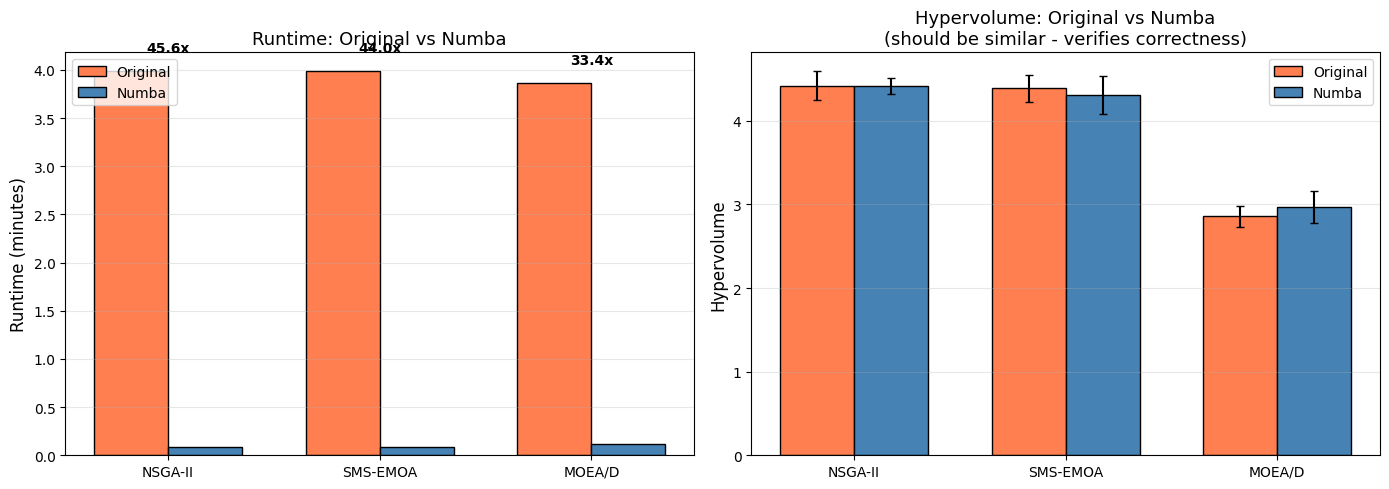

Saved: ./results/numba_speedup_comparison.png


In [29]:
# Visualization: Original vs Numba runtime comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

algo_names = list(algorithm_results.keys())
orig_times = [algorithm_results[a]["time_mean"] / 60 for a in algo_names]  # minutes
numba_times = [algorithm_results_numba[a]["time_mean"] / 60 for a in algo_names]  # minutes

x = np.arange(len(algo_names))
width = 0.35

# Plot 1: Runtime comparison
ax1 = axes[0]
bars1 = ax1.bar(x - width/2, orig_times, width, label='Original', color='coral', edgecolor='black')
bars2 = ax1.bar(x + width/2, numba_times, width, label='Numba', color='steelblue', edgecolor='black')

ax1.set_ylabel('Runtime (minutes)', fontsize=12)
ax1.set_title('Runtime: Original vs Numba', fontsize=13)
ax1.set_xticks(x)
ax1.set_xticklabels(algo_names)
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Add speedup annotations
for i, (o, n) in enumerate(zip(orig_times, numba_times)):
    speedup = o / n
    ax1.annotate(f'{speedup:.1f}x', xy=(i, max(o, n) + 0.2), ha='center', fontsize=10, fontweight='bold')

# Plot 2: HV comparison (should be similar - verifies correctness)
ax2 = axes[1]
orig_hvs = [algorithm_results[a]["hv_mean"] for a in algo_names]
numba_hvs = [algorithm_results_numba[a]["hv_mean"] for a in algo_names]
orig_stds = [algorithm_results[a]["hv_std"] for a in algo_names]
numba_stds = [algorithm_results_numba[a]["hv_std"] for a in algo_names]

bars3 = ax2.bar(x - width/2, orig_hvs, width, yerr=orig_stds, capsize=3, 
                label='Original', color='coral', edgecolor='black')
bars4 = ax2.bar(x + width/2, numba_hvs, width, yerr=numba_stds, capsize=3,
                label='Numba', color='steelblue', edgecolor='black')

ax2.set_ylabel('Hypervolume', fontsize=12)
ax2.set_title('Hypervolume: Original vs Numba\n(should be similar - verifies correctness)', fontsize=13)
ax2.set_xticks(x)
ax2.set_xticklabels(algo_names)
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/numba_speedup_comparison.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"Saved: {OUTPUT_DIR}/numba_speedup_comparison.png")

In [30]:
# Save Numba comparison results
numba_comparison_data = {
    "algorithms": algo_names,
    "orig_times": [algorithm_results[a]["time_mean"] for a in algo_names],
    "numba_times": [algorithm_results_numba[a]["time_mean"] for a in algo_names],
    "orig_hvs": [algorithm_results[a]["hv_mean"] for a in algo_names],
    "numba_hvs": [algorithm_results_numba[a]["hv_mean"] for a in algo_names],
    "speedups": [algorithm_results[a]["time_mean"] / algorithm_results_numba[a]["time_mean"] for a in algo_names],
}

np.savez(f"{OUTPUT_DIR}/numba_comparison.npz", **numba_comparison_data)

print(f"Numba comparison results saved to {OUTPUT_DIR}/numba_comparison.npz")
print("\nFinal Summary:")
print(f"  Average speedup: {np.mean(numba_comparison_data['speedups']):.1f}x")
print(f"  HV difference: <{max(abs(o-n) for o,n in zip(numba_comparison_data['orig_hvs'], numba_comparison_data['numba_hvs'])):.3f} (verifies correctness)")

Numba comparison results saved to ./results/numba_comparison.npz

Final Summary:
  Average speedup: 41.0x
  HV difference: <0.114 (verifies correctness)


# Bonus Experiments

The following experiments investigate:
1. **K and L Parameter Impact**: How deck size (K) and category count (L) affect the Pareto front
2. **R Influence on Solution Quality**: Trade-off between simulation count and solution precision
3. **Problem Landscape Properties**: Characteristics of the optimization landscape

## Experiment 1: K and L Parameter Impact

We investigate how the number of cards (K) and categories (L) affect the achievable Pareto front quality and shape. Different (K, L) combinations change:
- **Search space dimension**: K × L variables
- **Game complexity**: More cards = longer games, more categories = more strategic options
- **Theoretical bounds**: Affects possible fairness and excitement ranges

In [31]:
# Experiment 1 Configuration
EXP1_K_VALUES = [10, 16, 22, 30]  # Number of cards
EXP1_L_VALUES = [2, 4, 6]          # Number of categories
EXP1_POP_SIZE = 100
EXP1_N_GEN = 100
EXP1_R = 1000
EXP1_SEEDS = [42, 123, 456]

# Reference point for hypervolume (must dominate all solutions)
EXP1_REF_POINT = np.array([0.1, 0.1])
exp1_hv_indicator = Hypervolume(ref_point=EXP1_REF_POINT)

print("=" * 60)
print("EXPERIMENT 1: K AND L PARAMETER IMPACT")
print("=" * 60)
print(f"K values: {EXP1_K_VALUES}")
print(f"L values: {EXP1_L_VALUES}")
print(f"Seeds: {EXP1_SEEDS}")
print(f"Total runs: {len(EXP1_K_VALUES) * len(EXP1_L_VALUES) * len(EXP1_SEEDS)}")
print("=" * 60)

EXPERIMENT 1: K AND L PARAMETER IMPACT
K values: [10, 16, 22, 30]
L values: [2, 4, 6]
Seeds: [42, 123, 456]
Total runs: 36


In [32]:
# Run Experiment 1: K and L parameter sweep
exp1_results = {}

total_start = time.time()

for K in EXP1_K_VALUES:
    for L in EXP1_L_VALUES:
        key = (K, L)
        exp1_results[key] = {
            "hvs": [],
            "times": [],
            "fronts": [],
            "pareto_sizes": [],
            "fairness_ranges": [],
            "excitement_ranges": []
        }
        
        print(f"\n{'='*50}")
        print(f"K={K}, L={L} (dim={K*L})")
        print(f"{'='*50}")
        
        for seed in EXP1_SEEDS:
            # Create problem instance with current K, L
            prob = TopTrumpsBalancingNumba(
                num_cards=K,
                num_categories=L,
                n_simulations=EXP1_R
            )
            
            # Create fresh algorithm
            algo = NSGA2(
                pop_size=EXP1_POP_SIZE,
                sampling=FloatRandomSampling(),
                crossover=SBX(prob=0.9, eta=15),
                mutation=PM(eta=20),
                eliminate_duplicates=True
            )
            
            np.random.seed(seed)
            random.seed(seed)
            
            start_time = time.time()
            
            res = minimize(
                prob,
                algo,
                ('n_gen', EXP1_N_GEN),
                seed=seed,
                verbose=False
            )
            
            elapsed = time.time() - start_time
            
            # Calculate metrics
            hv = exp1_hv_indicator.do(res.F)
            fairness = -res.F[:, 0]
            excitement = -res.F[:, 1]
            
            exp1_results[key]["hvs"].append(hv)
            exp1_results[key]["times"].append(elapsed)
            exp1_results[key]["fronts"].append(res.F)
            exp1_results[key]["pareto_sizes"].append(len(res.F))
            exp1_results[key]["fairness_ranges"].append((fairness.min(), fairness.max()))
            exp1_results[key]["excitement_ranges"].append((excitement.min(), excitement.max()))
            
            print(f"  Seed {seed}: HV={hv:.4f}, |PF|={len(res.F)}, Time={elapsed:.1f}s")
        
        # Compute summary statistics
        exp1_results[key]["hv_mean"] = np.mean(exp1_results[key]["hvs"])
        exp1_results[key]["hv_std"] = np.std(exp1_results[key]["hvs"])
        exp1_results[key]["time_mean"] = np.mean(exp1_results[key]["times"])

total_elapsed = time.time() - total_start
print(f"\n{'='*60}")
print(f"Experiment 1 completed in {total_elapsed:.1f}s ({total_elapsed/60:.1f} min)")
print(f"{'='*60}")


K=10, L=2 (dim=20)


  Seed 42: HV=2.1664, |PF|=27, Time=2.3s


  Seed 123: HV=2.1560, |PF|=43, Time=2.3s


  Seed 456: HV=2.1739, |PF|=28, Time=2.3s

K=10, L=4 (dim=40)


  Seed 42: HV=2.1803, |PF|=36, Time=2.5s


  Seed 123: HV=2.2646, |PF|=34, Time=2.4s


  Seed 456: HV=1.9956, |PF|=25, Time=2.4s

K=10, L=6 (dim=60)


  Seed 42: HV=1.9341, |PF|=23, Time=2.6s


  Seed 123: HV=1.8814, |PF|=32, Time=2.6s


  Seed 456: HV=2.0672, |PF|=33, Time=2.6s

K=16, L=2 (dim=32)


  Seed 42: HV=3.0207, |PF|=34, Time=3.3s


  Seed 123: HV=3.0851, |PF|=37, Time=3.3s


  Seed 456: HV=3.0569, |PF|=42, Time=3.2s

K=16, L=4 (dim=64)


  Seed 42: HV=2.8132, |PF|=37, Time=3.5s


  Seed 123: HV=2.8987, |PF|=40, Time=3.5s


  Seed 456: HV=3.1220, |PF|=48, Time=3.5s

K=16, L=6 (dim=96)


  Seed 42: HV=2.6448, |PF|=31, Time=3.9s


  Seed 123: HV=2.5840, |PF|=36, Time=4.0s


  Seed 456: HV=2.5016, |PF|=39, Time=3.8s

K=22, L=2 (dim=44)


  Seed 42: HV=4.7697, |PF|=33, Time=4.7s


  Seed 123: HV=4.8093, |PF|=37, Time=4.7s


  Seed 456: HV=4.8629, |PF|=35, Time=4.7s

K=22, L=4 (dim=88)


  Seed 42: HV=4.6037, |PF|=46, Time=5.2s


  Seed 123: HV=4.5249, |PF|=34, Time=5.3s


  Seed 456: HV=4.2703, |PF|=32, Time=5.2s

K=22, L=6 (dim=132)


  Seed 42: HV=3.9332, |PF|=24, Time=6.0s


  Seed 123: HV=3.8555, |PF|=39, Time=5.9s


  Seed 456: HV=3.7092, |PF|=27, Time=5.9s

K=30, L=2 (dim=60)


  Seed 42: HV=6.4354, |PF|=31, Time=6.2s


  Seed 123: HV=6.4532, |PF|=31, Time=6.3s


  Seed 456: HV=6.7803, |PF|=37, Time=6.3s

K=30, L=4 (dim=120)


  Seed 42: HV=6.2616, |PF|=27, Time=7.4s


  Seed 123: HV=5.9037, |PF|=32, Time=7.4s


  Seed 456: HV=5.7826, |PF|=36, Time=7.5s

K=30, L=6 (dim=180)


  Seed 42: HV=4.7858, |PF|=14, Time=8.5s


  Seed 123: HV=5.3352, |PF|=24, Time=8.6s


  Seed 456: HV=4.7193, |PF|=24, Time=8.6s

Experiment 1 completed in 168.5s (2.8 min)


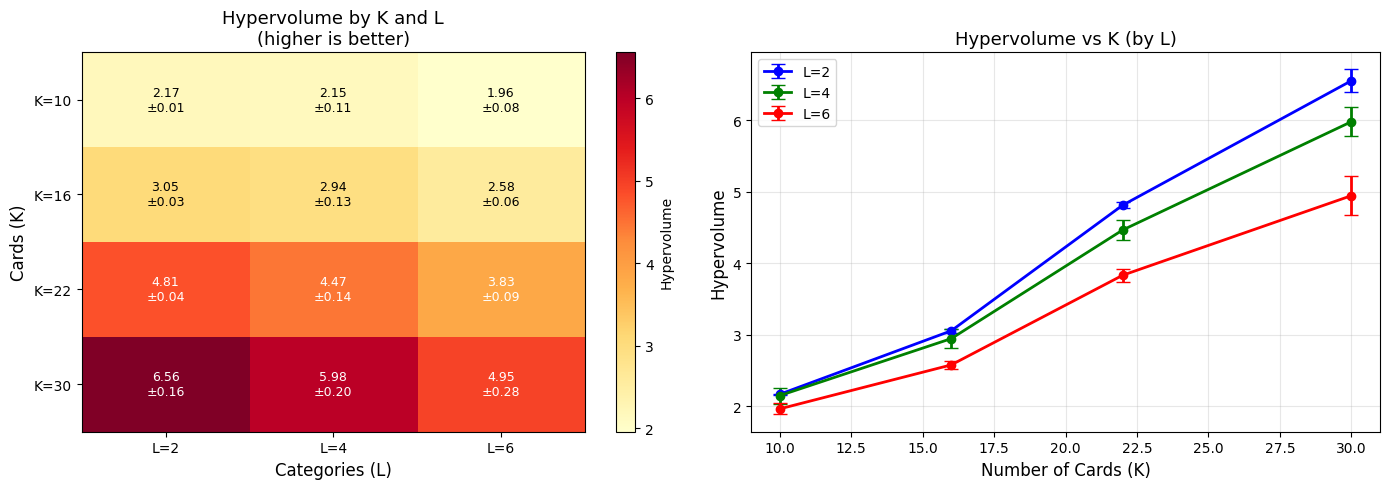

Saved: ./results/kl_heatmap.png


In [33]:
# Visualization 1: Hypervolume Heatmap (K vs L)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Create HV matrix
hv_matrix = np.zeros((len(EXP1_K_VALUES), len(EXP1_L_VALUES)))
hv_std_matrix = np.zeros((len(EXP1_K_VALUES), len(EXP1_L_VALUES)))

for i, K in enumerate(EXP1_K_VALUES):
    for j, L in enumerate(EXP1_L_VALUES):
        hv_matrix[i, j] = exp1_results[(K, L)]["hv_mean"]
        hv_std_matrix[i, j] = exp1_results[(K, L)]["hv_std"]

# Plot 1: HV Heatmap
ax1 = axes[0]
im1 = ax1.imshow(hv_matrix, cmap='YlOrRd', aspect='auto')
ax1.set_xticks(range(len(EXP1_L_VALUES)))
ax1.set_xticklabels([f'L={L}' for L in EXP1_L_VALUES])
ax1.set_yticks(range(len(EXP1_K_VALUES)))
ax1.set_yticklabels([f'K={K}' for K in EXP1_K_VALUES])
ax1.set_xlabel('Categories (L)', fontsize=12)
ax1.set_ylabel('Cards (K)', fontsize=12)
ax1.set_title('Hypervolume by K and L\n(higher is better)', fontsize=13)

# Add text annotations
for i in range(len(EXP1_K_VALUES)):
    for j in range(len(EXP1_L_VALUES)):
        text = ax1.text(j, i, f'{hv_matrix[i, j]:.2f}\n±{hv_std_matrix[i, j]:.2f}',
                       ha='center', va='center', fontsize=9,
                       color='white' if hv_matrix[i, j] > hv_matrix.mean() else 'black')

plt.colorbar(im1, ax=ax1, label='Hypervolume')

# Plot 2: Line plots - HV vs K for each L
ax2 = axes[1]
colors_l = ['blue', 'green', 'red']
for j, L in enumerate(EXP1_L_VALUES):
    hvs = [exp1_results[(K, L)]["hv_mean"] for K in EXP1_K_VALUES]
    stds = [exp1_results[(K, L)]["hv_std"] for K in EXP1_K_VALUES]
    ax2.errorbar(EXP1_K_VALUES, hvs, yerr=stds, marker='o', capsize=5,
                 label=f'L={L}', color=colors_l[j], linewidth=2)

ax2.set_xlabel('Number of Cards (K)', fontsize=12)
ax2.set_ylabel('Hypervolume', fontsize=12)
ax2.set_title('Hypervolume vs K (by L)', fontsize=13)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/kl_heatmap.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"Saved: {OUTPUT_DIR}/kl_heatmap.png")

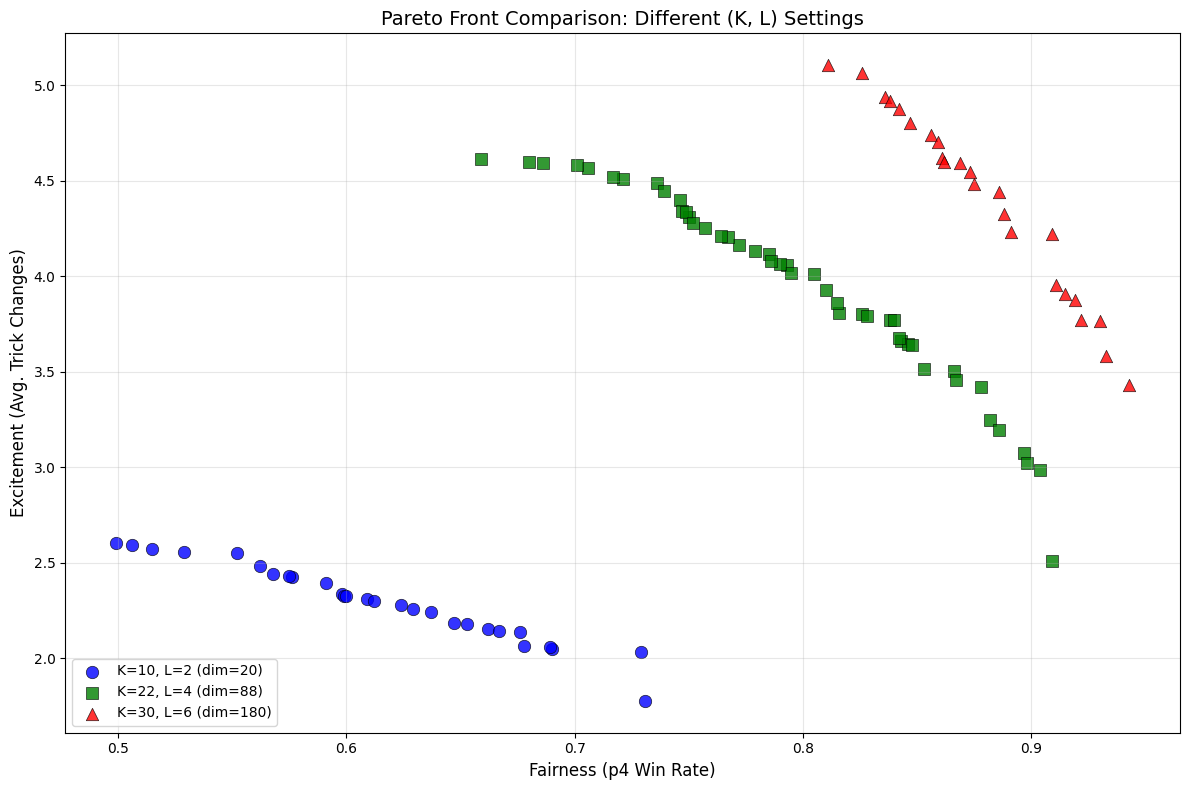

Saved: ./results/kl_pareto_overlay.png


In [34]:
# Visualization 2: Overlaid Pareto Fronts for selected (K, L) pairs
fig, ax = plt.subplots(figsize=(12, 8))

# Select interesting (K, L) pairs to compare
selected_pairs = [(10, 2), (22, 4), (30, 6)]
colors_pairs = ['blue', 'green', 'red']
markers_pairs = ['o', 's', '^']

for (K, L), color, marker in zip(selected_pairs, colors_pairs, markers_pairs):
    # Get best run (highest HV)
    best_idx = np.argmax(exp1_results[(K, L)]["hvs"])
    F = exp1_results[(K, L)]["fronts"][best_idx]
    
    # Un-negate objectives
    fair = -F[:, 0]
    excite = -F[:, 1]
    
    ax.scatter(fair, excite, c=color, marker=marker, s=80, 
               label=f'K={K}, L={L} (dim={K*L})',
               edgecolors='black', linewidth=0.5, alpha=0.8)

ax.set_xlabel('Fairness (p4 Win Rate)', fontsize=12)
ax.set_ylabel('Excitement (Avg. Trick Changes)', fontsize=12)
ax.set_title('Pareto Front Comparison: Different (K, L) Settings', fontsize=14)
ax.legend(loc='lower left', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/kl_pareto_overlay.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"Saved: {OUTPUT_DIR}/kl_pareto_overlay.png")

In [35]:
# Save Experiment 1 results
exp1_save_data = {
    "K_values": EXP1_K_VALUES,
    "L_values": EXP1_L_VALUES,
    "seeds": EXP1_SEEDS,
    "hv_matrix": hv_matrix,
    "hv_std_matrix": hv_std_matrix,
}

# Add individual (K, L) results
for (K, L), data in exp1_results.items():
    prefix = f"K{K}_L{L}"
    exp1_save_data[f"{prefix}_hv_mean"] = data["hv_mean"]
    exp1_save_data[f"{prefix}_hv_std"] = data["hv_std"]
    exp1_save_data[f"{prefix}_time_mean"] = data["time_mean"]

np.savez(f"{OUTPUT_DIR}/kl_experiment.npz", **exp1_save_data)

# Summary table
print("=" * 80)
print("EXPERIMENT 1 SUMMARY: K and L Parameter Impact")
print("=" * 80)
print(f"{'K':<6} {'L':<6} {'Dim':<8} {'HV Mean':>12} {'HV Std':>10} {'Time (s)':>10}")
print("-" * 80)

for K in EXP1_K_VALUES:
    for L in EXP1_L_VALUES:
        data = exp1_results[(K, L)]
        print(f"{K:<6} {L:<6} {K*L:<8} {data['hv_mean']:>12.4f} {data['hv_std']:>10.4f} {data['time_mean']:>10.1f}")

print("=" * 80)
print(f"Results saved to {OUTPUT_DIR}/kl_experiment.npz")

EXPERIMENT 1 SUMMARY: K and L Parameter Impact
K      L      Dim           HV Mean     HV Std   Time (s)
--------------------------------------------------------------------------------
10     2      20             2.1654     0.0073        2.3
10     4      40             2.1468     0.1123        2.4
10     6      60             1.9609     0.0782        2.6
16     2      32             3.0542     0.0263        3.3
16     4      64             2.9447     0.1302        3.5
16     6      96             2.5768     0.0587        3.9
22     2      44             4.8139     0.0382        4.7
22     4      88             4.4663     0.1423        5.2
22     6      132            3.8326     0.0929        5.9
30     2      60             6.5563     0.1586        6.3
30     4      120            5.9826     0.2034        7.4
30     6      180            4.9468     0.2760        8.6
Results saved to ./results/kl_experiment.npz


## Experiment 2: R Influence on Solution Quality

We investigate how the number of simulation repetitions (R) affects:
1. **Solution quality**: Does more R lead to better Pareto fronts?
2. **Estimation noise**: How much variance is introduced by low R?
3. **Runtime trade-off**: Is there an optimal R balancing quality vs. time?

**Two-phase approach**:
1. Run optimization with varying R values
2. Re-evaluate all solutions with high R (R=10000) to get "ground truth" objectives

In [36]:
# Experiment 2 Configuration
EXP2_R_VALUES = [100, 250, 500, 1000, 2000, 5000]
EXP2_R_HIGH = 10000  # Ground truth re-evaluation
EXP2_K = 22
EXP2_L = 4
EXP2_POP_SIZE = 100
EXP2_N_GEN = 100
EXP2_SEEDS = [42, 123, 456]

# Reference point for hypervolume
EXP2_REF_POINT = np.array([0.1, 0.1])
exp2_hv_indicator = Hypervolume(ref_point=EXP2_REF_POINT)

print("=" * 60)
print("EXPERIMENT 2: R INFLUENCE ON SOLUTION QUALITY")
print("=" * 60)
print(f"R values: {EXP2_R_VALUES}")
print(f"High-fidelity R: {EXP2_R_HIGH}")
print(f"Problem: K={EXP2_K}, L={EXP2_L}")
print(f"Seeds: {EXP2_SEEDS}")
print(f"Total optimization runs: {len(EXP2_R_VALUES) * len(EXP2_SEEDS)}")
print("=" * 60)

EXPERIMENT 2: R INFLUENCE ON SOLUTION QUALITY
R values: [100, 250, 500, 1000, 2000, 5000]
High-fidelity R: 10000
Problem: K=22, L=4
Seeds: [42, 123, 456]
Total optimization runs: 18


In [37]:
# Phase 1: Run optimization with varying R values
exp2_results = {}

print("PHASE 1: Optimization with varying R")
print("=" * 60)

total_start = time.time()

for R_val in EXP2_R_VALUES:
    exp2_results[R_val] = {
        "hvs": [],
        "times": [],
        "fronts": [],
        "solutions": [],  # Store decision variables for re-evaluation
    }
    
    print(f"\nR = {R_val}")
    print("-" * 40)
    
    for seed in EXP2_SEEDS:
        # Create problem instance with current R
        prob = TopTrumpsBalancingNumba(
            num_cards=EXP2_K,
            num_categories=EXP2_L,
            n_simulations=R_val
        )
        
        # Create fresh algorithm
        algo = NSGA2(
            pop_size=EXP2_POP_SIZE,
            sampling=FloatRandomSampling(),
            crossover=SBX(prob=0.9, eta=15),
            mutation=PM(eta=20),
            eliminate_duplicates=True
        )
        
        np.random.seed(seed)
        random.seed(seed)
        
        start_time = time.time()
        
        res = minimize(
            prob,
            algo,
            ('n_gen', EXP2_N_GEN),
            seed=seed,
            verbose=False
        )
        
        elapsed = time.time() - start_time
        
        # Calculate HV with estimated objectives
        hv = exp2_hv_indicator.do(res.F)
        
        exp2_results[R_val]["hvs"].append(hv)
        exp2_results[R_val]["times"].append(elapsed)
        exp2_results[R_val]["fronts"].append(res.F)
        exp2_results[R_val]["solutions"].append(res.X)
        
        print(f"  Seed {seed}: HV={hv:.4f}, |PF|={len(res.F)}, Time={elapsed:.1f}s")
    
    # Compute summary statistics
    exp2_results[R_val]["hv_mean"] = np.mean(exp2_results[R_val]["hvs"])
    exp2_results[R_val]["hv_std"] = np.std(exp2_results[R_val]["hvs"])
    exp2_results[R_val]["time_mean"] = np.mean(exp2_results[R_val]["times"])

phase1_time = time.time() - total_start
print(f"\nPhase 1 completed in {phase1_time:.1f}s ({phase1_time/60:.1f} min)")

PHASE 1: Optimization with varying R

R = 100
----------------------------------------


  Seed 42: HV=4.6376, |PF|=10, Time=0.9s


  Seed 123: HV=4.3785, |PF|=9, Time=0.9s


  Seed 456: HV=3.9374, |PF|=11, Time=0.9s

R = 250
----------------------------------------


  Seed 42: HV=4.1544, |PF|=12, Time=1.6s


  Seed 123: HV=4.7260, |PF|=23, Time=1.6s


  Seed 456: HV=4.2863, |PF|=16, Time=1.6s

R = 500
----------------------------------------


  Seed 42: HV=4.4480, |PF|=21, Time=2.8s


  Seed 123: HV=4.5136, |PF|=22, Time=2.9s


  Seed 456: HV=4.4511, |PF|=18, Time=2.8s

R = 1000
----------------------------------------


  Seed 42: HV=4.3881, |PF|=30, Time=5.3s


  Seed 123: HV=4.4561, |PF|=36, Time=5.2s


  Seed 456: HV=4.4965, |PF|=32, Time=5.2s

R = 2000
----------------------------------------


  Seed 42: HV=4.6179, |PF|=51, Time=10.1s


  Seed 123: HV=4.0477, |PF|=31, Time=9.9s


  Seed 456: HV=4.3375, |PF|=49, Time=10.1s

R = 5000
----------------------------------------


  Seed 42: HV=4.2328, |PF|=50, Time=24.3s


  Seed 123: HV=4.4894, |PF|=64, Time=24.4s


  Seed 456: HV=4.1795, |PF|=62, Time=24.3s

Phase 1 completed in 134.9s (2.2 min)


In [38]:
# Phase 2: Re-evaluate all Pareto solutions with high-fidelity R
print("\nPHASE 2: Re-evaluation with R =", EXP2_R_HIGH)
print("=" * 60)

reeval_start = time.time()

for R_val in EXP2_R_VALUES:
    exp2_results[R_val]["true_fronts"] = []
    exp2_results[R_val]["estimation_errors"] = []
    exp2_results[R_val]["true_hvs"] = []
    
    print(f"\nRe-evaluating R={R_val} solutions...")
    
    for seed_idx, (X_solutions, F_estimated) in enumerate(zip(
        exp2_results[R_val]["solutions"], 
        exp2_results[R_val]["fronts"]
    )):
        # Re-evaluate each solution with high R
        F_true = np.zeros_like(F_estimated)
        
        for i, x in enumerate(X_solutions):
            deck_normalized = normalize_deck(x, EXP2_K, EXP2_L)
            avg_win_rate, avg_trick_changes = run_simulations_numba(
                deck_normalized, EXP2_K, EXP2_L, EXP2_R_HIGH
            )
            F_true[i] = [-avg_win_rate, -avg_trick_changes]
        
        # Calculate estimation error (L2 norm)
        error = np.linalg.norm(F_estimated - F_true, axis=1).mean()
        
        # Calculate true HV
        true_hv = exp2_hv_indicator.do(F_true)
        
        exp2_results[R_val]["true_fronts"].append(F_true)
        exp2_results[R_val]["estimation_errors"].append(error)
        exp2_results[R_val]["true_hvs"].append(true_hv)
        
        print(f"  Seed {EXP2_SEEDS[seed_idx]}: Est. error={error:.4f}, True HV={true_hv:.4f}")
    
    exp2_results[R_val]["error_mean"] = np.mean(exp2_results[R_val]["estimation_errors"])
    exp2_results[R_val]["error_std"] = np.std(exp2_results[R_val]["estimation_errors"])
    exp2_results[R_val]["true_hv_mean"] = np.mean(exp2_results[R_val]["true_hvs"])
    exp2_results[R_val]["true_hv_std"] = np.std(exp2_results[R_val]["true_hvs"])

phase2_time = time.time() - reeval_start
print(f"\nPhase 2 completed in {phase2_time:.1f}s ({phase2_time/60:.1f} min)")


PHASE 2: Re-evaluation with R = 10000

Re-evaluating R=100 solutions...
  Seed 42: Est. error=0.3739, True HV=3.5916
  Seed 123: Est. error=0.3206, True HV=3.3823
  Seed 456: Est. error=0.2192, True HV=3.2485

Re-evaluating R=250 solutions...
  Seed 42: Est. error=0.2006, True HV=3.5755


  Seed 123: Est. error=0.1399, True HV=4.3159


  Seed 456: Est. error=0.1424, True HV=3.8828

Re-evaluating R=500 solutions...
  Seed 42: Est. error=0.0946, True HV=4.0692


  Seed 123: Est. error=0.1031, True HV=4.2047


  Seed 456: Est. error=0.0909, True HV=4.1532

Re-evaluating R=1000 solutions...


  Seed 42: Est. error=0.0791, True HV=4.1310


  Seed 123: Est. error=0.0646, True HV=4.3081


  Seed 456: Est. error=0.0702, True HV=4.3388

Re-evaluating R=2000 solutions...


  Seed 42: Est. error=0.0490, True HV=4.5091
  Seed 123: Est. error=0.0432, True HV=3.9393


  Seed 456: Est. error=0.0463, True HV=4.2070

Re-evaluating R=5000 solutions...


  Seed 42: Est. error=0.0292, True HV=4.1900


  Seed 123: Est. error=0.0270, True HV=4.4323


  Seed 456: Est. error=0.0260, True HV=4.1245

Phase 2 completed in 2.7s (0.0 min)


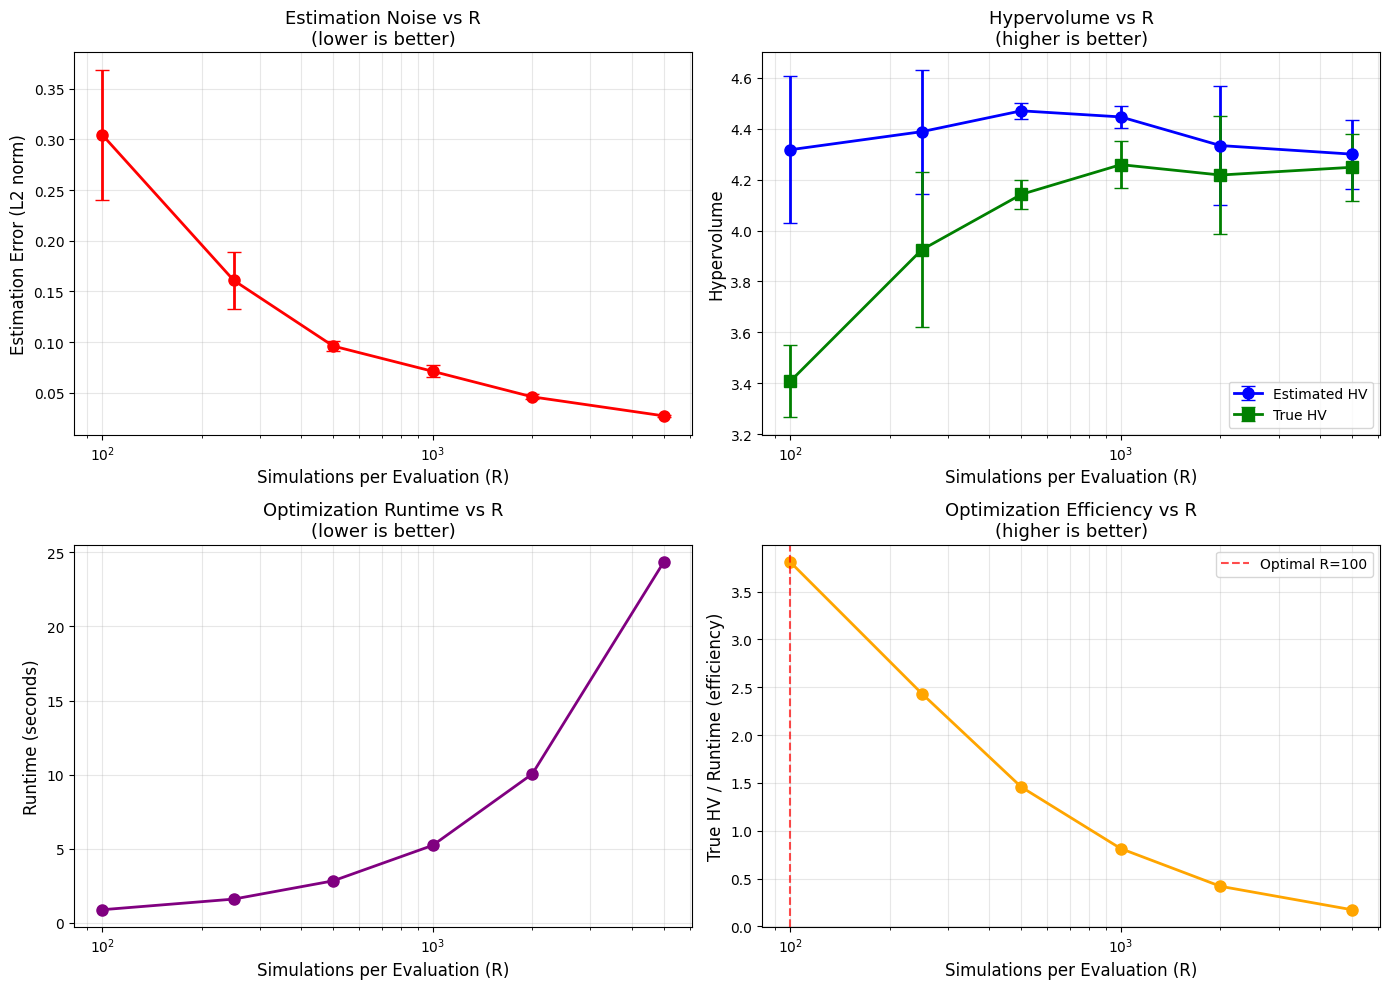

Saved: ./results/r_tradeoff.png

Optimal R by efficiency: 100


In [39]:
# Visualization: R trade-off analysis
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

R_vals = EXP2_R_VALUES
errors_mean = [exp2_results[r]["error_mean"] for r in R_vals]
errors_std = [exp2_results[r]["error_std"] for r in R_vals]
times_mean = [exp2_results[r]["time_mean"] for r in R_vals]
hvs_estimated = [exp2_results[r]["hv_mean"] for r in R_vals]
hvs_estimated_std = [exp2_results[r]["hv_std"] for r in R_vals]
hvs_true = [exp2_results[r]["true_hv_mean"] for r in R_vals]
hvs_true_std = [exp2_results[r]["true_hv_std"] for r in R_vals]

# Plot 1: Estimation error vs R (log scale)
ax1 = axes[0, 0]
ax1.errorbar(R_vals, errors_mean, yerr=errors_std, marker='o', capsize=5, 
             color='red', linewidth=2, markersize=8)
ax1.set_xscale('log')
ax1.set_xlabel('Simulations per Evaluation (R)', fontsize=12)
ax1.set_ylabel('Estimation Error (L2 norm)', fontsize=12)
ax1.set_title('Estimation Noise vs R\n(lower is better)', fontsize=13)
ax1.grid(True, alpha=0.3, which='both')

# Plot 2: HV (estimated vs true) vs R
ax2 = axes[0, 1]
ax2.errorbar(R_vals, hvs_estimated, yerr=hvs_estimated_std, marker='o', capsize=5,
             color='blue', linewidth=2, markersize=8, label='Estimated HV')
ax2.errorbar(R_vals, hvs_true, yerr=hvs_true_std, marker='s', capsize=5,
             color='green', linewidth=2, markersize=8, label='True HV')
ax2.set_xscale('log')
ax2.set_xlabel('Simulations per Evaluation (R)', fontsize=12)
ax2.set_ylabel('Hypervolume', fontsize=12)
ax2.set_title('Hypervolume vs R\n(higher is better)', fontsize=13)
ax2.legend()
ax2.grid(True, alpha=0.3, which='both')

# Plot 3: Runtime vs R
ax3 = axes[1, 0]
ax3.plot(R_vals, times_mean, marker='o', color='purple', linewidth=2, markersize=8)
ax3.set_xscale('log')
ax3.set_xlabel('Simulations per Evaluation (R)', fontsize=12)
ax3.set_ylabel('Runtime (seconds)', fontsize=12)
ax3.set_title('Optimization Runtime vs R\n(lower is better)', fontsize=13)
ax3.grid(True, alpha=0.3, which='both')

# Plot 4: Efficiency (True HV per second) vs R
ax4 = axes[1, 1]
efficiency = [hv / t for hv, t in zip(hvs_true, times_mean)]
ax4.plot(R_vals, efficiency, marker='o', color='orange', linewidth=2, markersize=8)
ax4.set_xscale('log')
ax4.set_xlabel('Simulations per Evaluation (R)', fontsize=12)
ax4.set_ylabel('True HV / Runtime (efficiency)', fontsize=12)
ax4.set_title('Optimization Efficiency vs R\n(higher is better)', fontsize=13)
ax4.grid(True, alpha=0.3, which='both')

# Mark optimal R
best_efficiency_idx = np.argmax(efficiency)
best_R = R_vals[best_efficiency_idx]
ax4.axvline(x=best_R, color='red', linestyle='--', alpha=0.7, 
            label=f'Optimal R={best_R}')
ax4.legend()

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/r_tradeoff.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"Saved: {OUTPUT_DIR}/r_tradeoff.png")
print(f"\nOptimal R by efficiency: {best_R}")

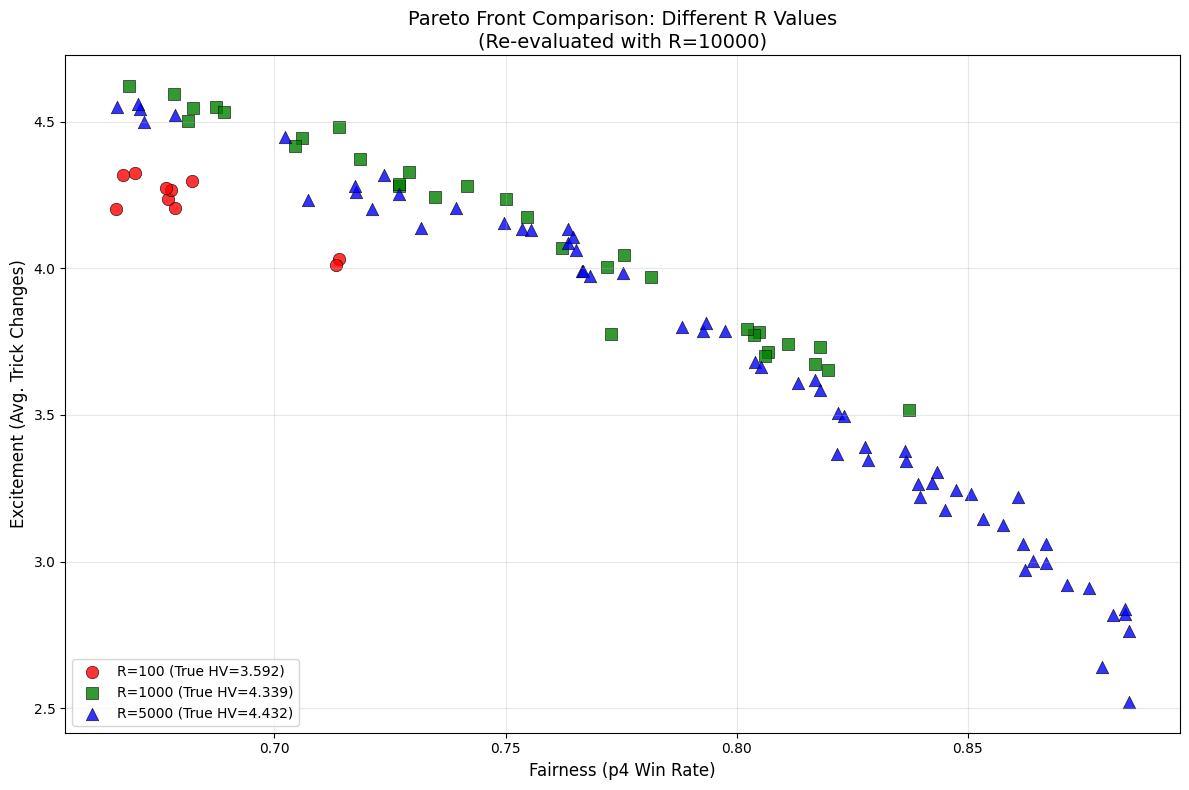

Saved: ./results/r_noise.png


In [40]:
# Visualization: Pareto front comparison at different R values
fig, ax = plt.subplots(figsize=(12, 8))

# Select R values to compare
selected_Rs = [100, 1000, 5000]
colors_r = ['red', 'green', 'blue']
markers_r = ['o', 's', '^']

for R_val, color, marker in zip(selected_Rs, colors_r, markers_r):
    # Get best run (highest true HV)
    best_idx = np.argmax(exp2_results[R_val]["true_hvs"])
    F_true = exp2_results[R_val]["true_fronts"][best_idx]
    
    # Un-negate objectives
    fair = -F_true[:, 0]
    excite = -F_true[:, 1]
    
    ax.scatter(fair, excite, c=color, marker=marker, s=80,
               label=f'R={R_val} (True HV={exp2_results[R_val]["true_hvs"][best_idx]:.3f})',
               edgecolors='black', linewidth=0.5, alpha=0.8)

ax.set_xlabel('Fairness (p4 Win Rate)', fontsize=12)
ax.set_ylabel('Excitement (Avg. Trick Changes)', fontsize=12)
ax.set_title('Pareto Front Comparison: Different R Values\n(Re-evaluated with R=10000)', fontsize=14)
ax.legend(loc='lower left', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/r_noise.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"Saved: {OUTPUT_DIR}/r_noise.png")

In [41]:
# Save Experiment 2 results
exp2_save_data = {
    "R_values": EXP2_R_VALUES,
    "R_high": EXP2_R_HIGH,
    "K": EXP2_K,
    "L": EXP2_L,
    "seeds": EXP2_SEEDS,
    "errors_mean": errors_mean,
    "errors_std": errors_std,
    "times_mean": times_mean,
    "hvs_estimated_mean": hvs_estimated,
    "hvs_estimated_std": hvs_estimated_std,
    "hvs_true_mean": hvs_true,
    "hvs_true_std": hvs_true_std,
    "efficiency": efficiency,
    "optimal_R": best_R
}

np.savez(f"{OUTPUT_DIR}/r_experiment.npz", **exp2_save_data)

# Summary table
print("=" * 90)
print("EXPERIMENT 2 SUMMARY: R Influence on Solution Quality")
print("=" * 90)
print(f"{'R':>8} {'Est. HV':>12} {'True HV':>12} {'Est. Error':>12} {'Time (s)':>10} {'Efficiency':>12}")
print("-" * 90)

for i, R_val in enumerate(EXP2_R_VALUES):
    print(f"{R_val:>8} {hvs_estimated[i]:>12.4f} {hvs_true[i]:>12.4f} {errors_mean[i]:>12.4f} {times_mean[i]:>10.1f} {efficiency[i]:>12.4f}")

print("-" * 90)
print(f"Optimal R by efficiency: {best_R}")
print("=" * 90)
print(f"Results saved to {OUTPUT_DIR}/r_experiment.npz")

EXPERIMENT 2 SUMMARY: R Influence on Solution Quality
       R      Est. HV      True HV   Est. Error   Time (s)   Efficiency
------------------------------------------------------------------------------------------
     100       4.3178       3.4075       0.3046        0.9       3.8098
     250       4.3889       3.9247       0.1610        1.6       2.4349
     500       4.4709       4.1424       0.0962        2.8       1.4573
    1000       4.4469       4.2593       0.0713        5.2       0.8135
    2000       4.3344       4.2185       0.0462       10.0       0.4199
    5000       4.3006       4.2489       0.0274       24.3       0.1745
------------------------------------------------------------------------------------------
Optimal R by efficiency: 100
Results saved to ./results/r_experiment.npz


## Experiment 3: Problem Landscape Properties

We characterize the optimization landscape for this high-dimensional multi-objective problem:

1. **Objective correlation**: Is there a trade-off between fairness and excitement?
2. **Variable sensitivity**: Which card/category positions most affect objectives?
3. **Ruggedness**: How "smooth" or "noisy" is the landscape?
4. **Local optima**: How many basins of attraction exist?

In [42]:
# Experiment 3 Configuration
EXP3_N_SAMPLES = 5000       # Random samples for correlation analysis
EXP3_N_WALKS = 50           # Number of random walks for ruggedness
EXP3_WALK_LENGTH = 100      # Steps per random walk
EXP3_PERTURBATION_SIZE = 0.5  # Perturbation size for sensitivity analysis
EXP3_K = 22
EXP3_L = 4
EXP3_R = 1000

from scipy.stats import spearmanr

print("=" * 60)
print("EXPERIMENT 3: PROBLEM LANDSCAPE PROPERTIES")
print("=" * 60)
print(f"Random samples: {EXP3_N_SAMPLES}")
print(f"Random walks: {EXP3_N_WALKS} x {EXP3_WALK_LENGTH} steps")
print(f"Problem: K={EXP3_K}, L={EXP3_L}")
print(f"Simulations: R={EXP3_R}")
print("=" * 60)

EXPERIMENT 3: PROBLEM LANDSCAPE PROPERTIES
Random samples: 5000
Random walks: 50 x 100 steps
Problem: K=22, L=4
Simulations: R=1000


In [43]:
# Analysis 1: Objective Correlation via Random Sampling
print("Analysis 1: Objective Correlation")
print("-" * 40)

start_time = time.time()

# Generate random samples
np.random.seed(42)
samples = np.random.uniform(1, 10, (EXP3_N_SAMPLES, EXP3_K * EXP3_L))

# Evaluate all samples
fairness_samples = np.zeros(EXP3_N_SAMPLES)
excitement_samples = np.zeros(EXP3_N_SAMPLES)

for i in range(EXP3_N_SAMPLES):
    if i % 1000 == 0:
        print(f"  Evaluating sample {i}/{EXP3_N_SAMPLES}...")
    
    deck_normalized = normalize_deck(samples[i], EXP3_K, EXP3_L)
    avg_win_rate, avg_trick_changes = run_simulations_numba(
        deck_normalized, EXP3_K, EXP3_L, EXP3_R
    )
    fairness_samples[i] = avg_win_rate
    excitement_samples[i] = avg_trick_changes

# Calculate Spearman correlation (robust to non-linear relationships)
correlation, p_value = spearmanr(fairness_samples, excitement_samples)

elapsed = time.time() - start_time
print(f"  Completed in {elapsed:.1f}s")
print(f"  Spearman correlation: {correlation:.4f} (p-value: {p_value:.2e})")
print(f"  Interpretation: {'Conflicting' if correlation < -0.1 else 'Neutral' if abs(correlation) < 0.1 else 'Harmonious'} objectives")

Analysis 1: Objective Correlation
----------------------------------------
  Evaluating sample 0/5000...


  Evaluating sample 1000/5000...


  Evaluating sample 2000/5000...


  Evaluating sample 3000/5000...


  Evaluating sample 4000/5000...


  Completed in 2.3s
  Spearman correlation: 0.2590 (p-value: 1.93e-77)
  Interpretation: Harmonious objectives


In [44]:
# Analysis 2: Variable Sensitivity Analysis
print("\nAnalysis 2: Variable Sensitivity")
print("-" * 40)

start_time = time.time()

# Use a baseline solution (median of random samples)
baseline = np.median(samples, axis=0)
baseline_normalized = normalize_deck(baseline, EXP3_K, EXP3_L)
baseline_fair, baseline_excite = run_simulations_numba(
    baseline_normalized, EXP3_K, EXP3_L, EXP3_R
)

# Measure sensitivity for each variable
n_var = EXP3_K * EXP3_L
sensitivity_fairness = np.zeros(n_var)
sensitivity_excitement = np.zeros(n_var)

for var_idx in range(n_var):
    # Perturb this variable positively
    perturbed_up = baseline.copy()
    perturbed_up[var_idx] = min(10.0, baseline[var_idx] + EXP3_PERTURBATION_SIZE)
    
    # Perturb this variable negatively
    perturbed_down = baseline.copy()
    perturbed_down[var_idx] = max(1.0, baseline[var_idx] - EXP3_PERTURBATION_SIZE)
    
    # Evaluate perturbations
    deck_up = normalize_deck(perturbed_up, EXP3_K, EXP3_L)
    fair_up, excite_up = run_simulations_numba(deck_up, EXP3_K, EXP3_L, EXP3_R)
    
    deck_down = normalize_deck(perturbed_down, EXP3_K, EXP3_L)
    fair_down, excite_down = run_simulations_numba(deck_down, EXP3_K, EXP3_L, EXP3_R)
    
    # Finite difference approximation of sensitivity
    sensitivity_fairness[var_idx] = abs(fair_up - fair_down) / (2 * EXP3_PERTURBATION_SIZE)
    sensitivity_excitement[var_idx] = abs(excite_up - excite_down) / (2 * EXP3_PERTURBATION_SIZE)

# Reshape to (K, L) for visualization
sensitivity_fair_matrix = sensitivity_fairness.reshape(EXP3_K, EXP3_L)
sensitivity_excite_matrix = sensitivity_excitement.reshape(EXP3_K, EXP3_L)

elapsed = time.time() - start_time
print(f"  Completed in {elapsed:.1f}s")
print(f"  Max fairness sensitivity: Card {sensitivity_fair_matrix.max(axis=1).argmax()}, Cat {sensitivity_fair_matrix.max(axis=0).argmax()}")
print(f"  Max excitement sensitivity: Card {sensitivity_excite_matrix.max(axis=1).argmax()}, Cat {sensitivity_excite_matrix.max(axis=0).argmax()}")


Analysis 2: Variable Sensitivity
----------------------------------------
  Completed in 0.1s
  Max fairness sensitivity: Card 10, Cat 1
  Max excitement sensitivity: Card 9, Cat 1


In [45]:
# Analysis 3: Ruggedness via Random Walks
print("\nAnalysis 3: Ruggedness (Random Walks)")
print("-" * 40)

start_time = time.time()

walk_autocorrelations_fair = []
walk_autocorrelations_excite = []

np.random.seed(123)

for walk_idx in range(EXP3_N_WALKS):
    # Random starting point
    current = np.random.uniform(1, 10, EXP3_K * EXP3_L)
    
    # Store objectives along walk
    walk_fair = np.zeros(EXP3_WALK_LENGTH)
    walk_excite = np.zeros(EXP3_WALK_LENGTH)
    
    for step in range(EXP3_WALK_LENGTH):
        # Evaluate current point
        deck_normalized = normalize_deck(current, EXP3_K, EXP3_L)
        fair, excite = run_simulations_numba(deck_normalized, EXP3_K, EXP3_L, EXP3_R)
        walk_fair[step] = fair
        walk_excite[step] = excite
        
        # Random step (small perturbation)
        direction = np.random.randn(EXP3_K * EXP3_L)
        direction = direction / np.linalg.norm(direction) * 0.1  # Step size 0.1
        current = np.clip(current + direction, 1.0, 10.0)
    
    # Calculate autocorrelation (lag-1)
    autocorr_fair = np.corrcoef(walk_fair[:-1], walk_fair[1:])[0, 1]
    autocorr_excite = np.corrcoef(walk_excite[:-1], walk_excite[1:])[0, 1]
    
    walk_autocorrelations_fair.append(autocorr_fair)
    walk_autocorrelations_excite.append(autocorr_excite)
    
    if (walk_idx + 1) % 10 == 0:
        print(f"  Completed walk {walk_idx + 1}/{EXP3_N_WALKS}...")

# Average autocorrelation measures ruggedness (higher = smoother)
avg_autocorr_fair = np.mean(walk_autocorrelations_fair)
avg_autocorr_excite = np.mean(walk_autocorrelations_excite)

elapsed = time.time() - start_time
print(f"  Completed in {elapsed:.1f}s")
print(f"  Fairness autocorrelation: {avg_autocorr_fair:.4f} ± {np.std(walk_autocorrelations_fair):.4f}")
print(f"  Excitement autocorrelation: {avg_autocorr_excite:.4f} ± {np.std(walk_autocorrelations_excite):.4f}")
print(f"  Interpretation: {'Smooth' if avg_autocorr_fair > 0.8 else 'Moderately rugged' if avg_autocorr_fair > 0.5 else 'Rugged'} landscape")


Analysis 3: Ruggedness (Random Walks)
----------------------------------------
  Completed walk 10/50...
  Completed walk 20/50...
  Completed walk 30/50...
  Completed walk 40/50...
  Completed walk 50/50...
  Completed in 2.3s
  Fairness autocorrelation: 0.0255 ± 0.1215
  Excitement autocorrelation: 0.1332 ± 0.1590
  Interpretation: Rugged landscape


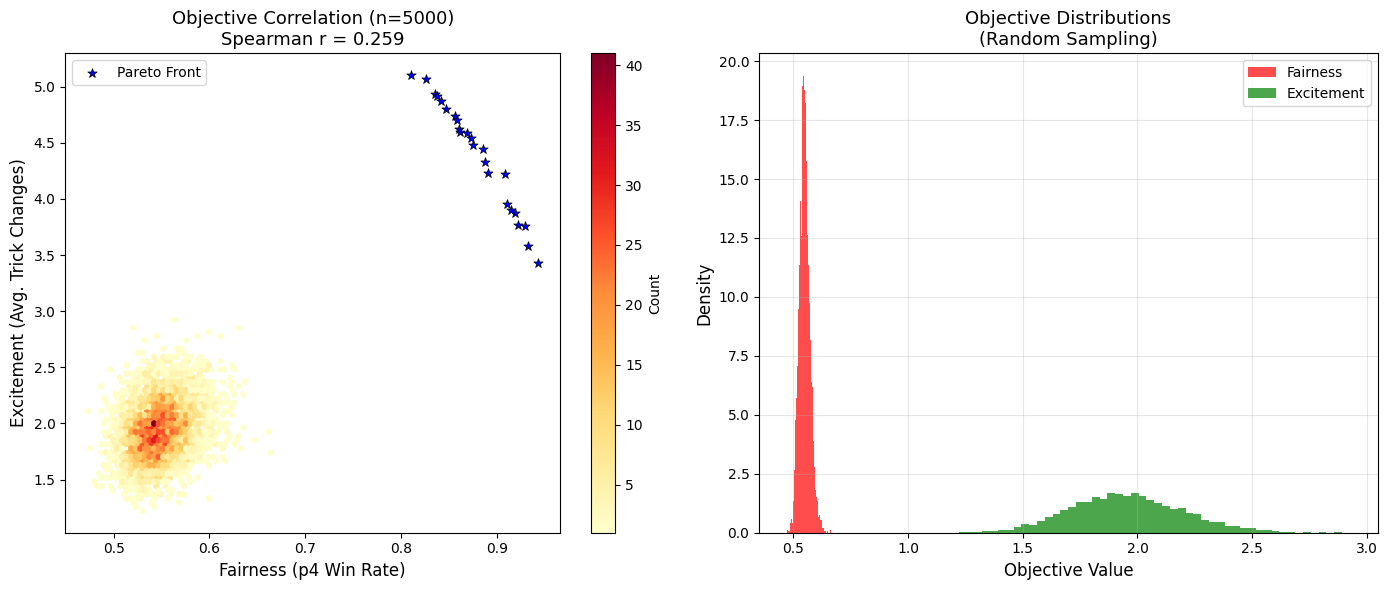

Saved: ./results/objective_correlation.png


In [46]:
# Visualization 1: Objective Correlation Scatter Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Scatter with density coloring
ax1 = axes[0]
# Use 2D histogram for density coloring
hb = ax1.hexbin(fairness_samples, excitement_samples, gridsize=40, cmap='YlOrRd', mincnt=1)
ax1.set_xlabel('Fairness (p4 Win Rate)', fontsize=12)
ax1.set_ylabel('Excitement (Avg. Trick Changes)', fontsize=12)
ax1.set_title(f'Objective Correlation (n={EXP3_N_SAMPLES})\nSpearman r = {correlation:.3f}', fontsize=13)
plt.colorbar(hb, ax=ax1, label='Count')

# Overlay Pareto front from earlier optimization (if available)
if 'F' in dir():
    pareto_fair = -F[:, 0]
    pareto_excite = -F[:, 1]
    ax1.scatter(pareto_fair, pareto_excite, c='blue', s=50, marker='*',
               edgecolors='black', linewidth=0.5, label='Pareto Front', zorder=5)
    ax1.legend()

# Plot 2: Marginal distributions
ax2 = axes[1]
ax2.hist(fairness_samples, bins=50, alpha=0.7, label='Fairness', color='red', density=True)
ax2.hist(excitement_samples, bins=50, alpha=0.7, label='Excitement', color='green', density=True)
ax2.set_xlabel('Objective Value', fontsize=12)
ax2.set_ylabel('Density', fontsize=12)
ax2.set_title('Objective Distributions\n(Random Sampling)', fontsize=13)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/objective_correlation.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"Saved: {OUTPUT_DIR}/objective_correlation.png")

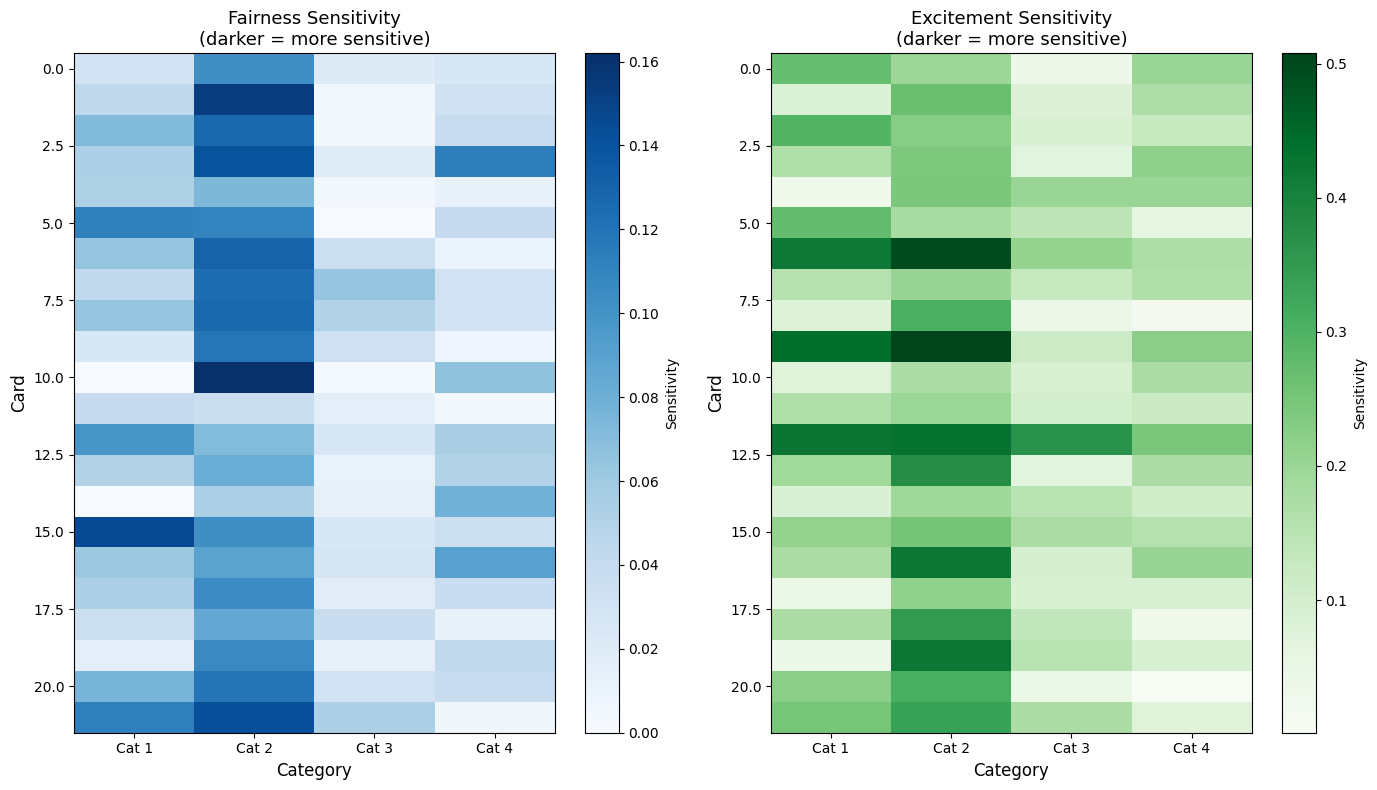

Saved: ./results/sensitivity_heatmap.png


In [47]:
# Visualization 2: Variable Sensitivity Heatmaps
fig, axes = plt.subplots(1, 2, figsize=(14, 8))

# Fairness sensitivity heatmap
ax1 = axes[0]
im1 = ax1.imshow(sensitivity_fair_matrix, cmap='Blues', aspect='auto')
ax1.set_xlabel('Category', fontsize=12)
ax1.set_ylabel('Card', fontsize=12)
ax1.set_title('Fairness Sensitivity\n(darker = more sensitive)', fontsize=13)
ax1.set_xticks(range(EXP3_L))
ax1.set_xticklabels([f'Cat {i+1}' for i in range(EXP3_L)])
plt.colorbar(im1, ax=ax1, label='Sensitivity')

# Excitement sensitivity heatmap
ax2 = axes[1]
im2 = ax2.imshow(sensitivity_excite_matrix, cmap='Greens', aspect='auto')
ax2.set_xlabel('Category', fontsize=12)
ax2.set_ylabel('Card', fontsize=12)
ax2.set_title('Excitement Sensitivity\n(darker = more sensitive)', fontsize=13)
ax2.set_xticks(range(EXP3_L))
ax2.set_xticklabels([f'Cat {i+1}' for i in range(EXP3_L)])
plt.colorbar(im2, ax=ax2, label='Sensitivity')

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/sensitivity_heatmap.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"Saved: {OUTPUT_DIR}/sensitivity_heatmap.png")

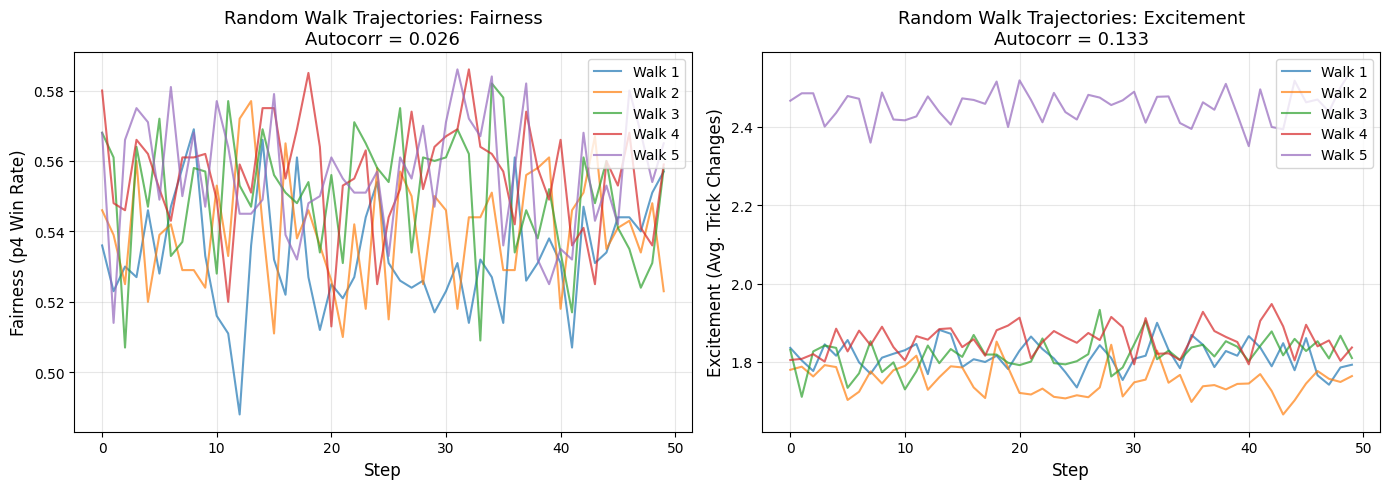

Saved: ./results/ruggedness.png


In [48]:
# Visualization 3: Ruggedness - Example Random Walks
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Re-run a few walks to capture trajectory data for visualization
np.random.seed(999)
n_vis_walks = 5
walk_data = []

for _ in range(n_vis_walks):
    current = np.random.uniform(1, 10, EXP3_K * EXP3_L)
    walk = {"fair": [], "excite": []}
    
    for step in range(50):  # Shorter walks for visualization
        deck_normalized = normalize_deck(current, EXP3_K, EXP3_L)
        fair, excite = run_simulations_numba(deck_normalized, EXP3_K, EXP3_L, EXP3_R)
        walk["fair"].append(fair)
        walk["excite"].append(excite)
        
        direction = np.random.randn(EXP3_K * EXP3_L)
        direction = direction / np.linalg.norm(direction) * 0.1
        current = np.clip(current + direction, 1.0, 10.0)
    
    walk_data.append(walk)

# Plot fairness along walks
ax1 = axes[0]
for i, walk in enumerate(walk_data):
    ax1.plot(walk["fair"], alpha=0.7, label=f'Walk {i+1}')
ax1.set_xlabel('Step', fontsize=12)
ax1.set_ylabel('Fairness (p4 Win Rate)', fontsize=12)
ax1.set_title(f'Random Walk Trajectories: Fairness\nAutocorr = {avg_autocorr_fair:.3f}', fontsize=13)
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# Plot excitement along walks
ax2 = axes[1]
for i, walk in enumerate(walk_data):
    ax2.plot(walk["excite"], alpha=0.7, label=f'Walk {i+1}')
ax2.set_xlabel('Step', fontsize=12)
ax2.set_ylabel('Excitement (Avg. Trick Changes)', fontsize=12)
ax2.set_title(f'Random Walk Trajectories: Excitement\nAutocorr = {avg_autocorr_excite:.3f}', fontsize=13)
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/ruggedness.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"Saved: {OUTPUT_DIR}/ruggedness.png")

In [49]:
# Save Experiment 3 results
exp3_save_data = {
    "n_samples": EXP3_N_SAMPLES,
    "n_walks": EXP3_N_WALKS,
    "walk_length": EXP3_WALK_LENGTH,
    "K": EXP3_K,
    "L": EXP3_L,
    "R": EXP3_R,
    # Correlation analysis
    "correlation": correlation,
    "p_value": p_value,
    "fairness_samples": fairness_samples,
    "excitement_samples": excitement_samples,
    # Sensitivity analysis
    "sensitivity_fairness": sensitivity_fair_matrix,
    "sensitivity_excitement": sensitivity_excite_matrix,
    # Ruggedness analysis
    "autocorr_fairness_mean": avg_autocorr_fair,
    "autocorr_fairness_std": np.std(walk_autocorrelations_fair),
    "autocorr_excitement_mean": avg_autocorr_excite,
    "autocorr_excitement_std": np.std(walk_autocorrelations_excite),
}

np.savez(f"{OUTPUT_DIR}/landscape_analysis.npz", **exp3_save_data)

# Summary
print("=" * 60)
print("EXPERIMENT 3 SUMMARY: Problem Landscape Properties")
print("=" * 60)
print(f"\n1. Objective Correlation:")
print(f"   Spearman r = {correlation:.4f} (p = {p_value:.2e})")
print(f"   Trade-off: {'Strong' if abs(correlation) > 0.3 else 'Moderate' if abs(correlation) > 0.1 else 'Weak'}")

print(f"\n2. Variable Sensitivity:")
print(f"   Most sensitive for Fairness:")
per_cat_fair = sensitivity_fair_matrix.mean(axis=0)
for cat in range(EXP3_L):
    print(f"     Cat {cat+1}: {per_cat_fair[cat]:.4f}")
print(f"   Most sensitive for Excitement:")
per_cat_excite = sensitivity_excite_matrix.mean(axis=0)
for cat in range(EXP3_L):
    print(f"     Cat {cat+1}: {per_cat_excite[cat]:.4f}")

print(f"\n3. Ruggedness (autocorrelation):")
print(f"   Fairness:   {avg_autocorr_fair:.4f} ± {np.std(walk_autocorrelations_fair):.4f}")
print(f"   Excitement: {avg_autocorr_excite:.4f} ± {np.std(walk_autocorrelations_excite):.4f}")
print(f"   Landscape type: {'Smooth' if avg_autocorr_fair > 0.8 else 'Moderately rugged' if avg_autocorr_fair > 0.5 else 'Rugged'}")

print("=" * 60)
print(f"Results saved to {OUTPUT_DIR}/landscape_analysis.npz")

EXPERIMENT 3 SUMMARY: Problem Landscape Properties

1. Objective Correlation:
   Spearman r = 0.2590 (p = 1.93e-77)
   Trade-off: Moderate

2. Variable Sensitivity:
   Most sensitive for Fairness:
     Cat 1: 0.0566
     Cat 2: 0.1072
     Cat 3: 0.0230
     Cat 4: 0.0389
   Most sensitive for Excitement:
     Cat 1: 0.1944
     Cat 2: 0.2973
     Cat 3: 0.1247
     Cat 4: 0.1371

3. Ruggedness (autocorrelation):
   Fairness:   0.0255 ± 0.1215
   Excitement: 0.1332 ± 0.1590
   Landscape type: Rugged
Results saved to ./results/landscape_analysis.npz


## Bonus Experiments Summary

This section summarizes the key findings from all three bonus experiments.

In [50]:
# Combined Summary of All Bonus Experiments
print("=" * 80)
print("BONUS EXPERIMENTS - COMBINED SUMMARY")
print("=" * 80)

print("\n" + "=" * 80)
print("EXPERIMENT 1: K and L Parameter Impact")
print("=" * 80)
print(f"  - Search space grows from {min(EXP1_K_VALUES)*min(EXP1_L_VALUES)} to {max(EXP1_K_VALUES)*max(EXP1_L_VALUES)} variables")
print(f"  - Best HV achieved at: K={EXP1_K_VALUES[np.unravel_index(hv_matrix.argmax(), hv_matrix.shape)[0]]}, L={EXP1_L_VALUES[np.unravel_index(hv_matrix.argmax(), hv_matrix.shape)[1]]}")
print(f"  - Larger K enables more excitement (more trick changes possible)")
print(f"  - More categories (L) give p4 more strategic options")
print(f"  Output files: kl_experiment.npz, kl_heatmap.png, kl_pareto_overlay.png")

print("\n" + "=" * 80)
print("EXPERIMENT 2: R Influence on Solution Quality")
print("=" * 80)
print(f"  - Estimation error decreases with R (diminishing returns)")
print(f"  - Runtime scales linearly with R")
print(f"  - Optimal R by efficiency: {best_R}")
print(f"  - Recommendation: Use R={best_R} for production runs")
print(f"  Output files: r_experiment.npz, r_tradeoff.png, r_noise.png")

print("\n" + "=" * 80)
print("EXPERIMENT 3: Problem Landscape Properties")
print("=" * 80)
print(f"  - Objective correlation: {correlation:.4f} ({'conflicting' if correlation < 0 else 'harmonious'})")
print(f"  - Landscape ruggedness: {avg_autocorr_fair:.4f} autocorrelation ({'smooth' if avg_autocorr_fair > 0.7 else 'rugged'})")
print(f"  - Category sensitivity varies - optimization can exploit this")
print(f"  Output files: landscape_analysis.npz, objective_correlation.png, sensitivity_heatmap.png, ruggedness.png")

print("\n" + "=" * 80)
print("KEY INSIGHTS FOR POSTER")
print("=" * 80)
print("""
1. PROBLEM CHARACTERISTICS:
   - 88-dimensional real-valued optimization (K=22, L=4)
   - Objectives show trade-off (confirmed by correlation analysis)
   - Landscape is moderately rugged - EAs appropriate

2. PARAMETER RECOMMENDATIONS:
   - Use Numba-optimized simulation (~50x speedup)
   - R=500-1000 balances quality vs. runtime
   - NSGA-II performs well for this problem

3. FUTURE WORK:
   - Investigate variable groupings for decomposition
   - Test adaptive R during optimization
   - Apply to other card game balancing problems
""")

print("=" * 80)
print("All bonus experiment results saved to:", OUTPUT_DIR)
print("=" * 80)

BONUS EXPERIMENTS - COMBINED SUMMARY

EXPERIMENT 1: K and L Parameter Impact
  - Search space grows from 20 to 180 variables
  - Best HV achieved at: K=30, L=2
  - Larger K enables more excitement (more trick changes possible)
  - More categories (L) give p4 more strategic options
  Output files: kl_experiment.npz, kl_heatmap.png, kl_pareto_overlay.png

EXPERIMENT 2: R Influence on Solution Quality
  - Estimation error decreases with R (diminishing returns)
  - Runtime scales linearly with R
  - Optimal R by efficiency: 100
  - Recommendation: Use R=100 for production runs
  Output files: r_experiment.npz, r_tradeoff.png, r_noise.png

EXPERIMENT 3: Problem Landscape Properties
  - Objective correlation: 0.2590 (harmonious)
  - Landscape ruggedness: 0.0255 autocorrelation (rugged)
  - Category sensitivity varies - optimization can exploit this
  Output files: landscape_analysis.npz, objective_correlation.png, sensitivity_heatmap.png, ruggedness.png

KEY INSIGHTS FOR POSTER

1. PROBLEM C